In [1]:
from keras.layers import Conv3D, Input, RepeatVector, merge, Activation, UpSampling3D, Conv3DTranspose
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.layers.advanced_activations import PReLU, Softmax
from keras.activations import softmax
from keras import activations, initializers, regularizers
from keras.optimizers import SGD
from keras.utils import Sequence
from keras.callbacks import LearningRateScheduler
import tensorflow as tf
import keras.backend as K

from skimage import io, img_as_ubyte, img_as_float, img_as_uint


import numpy as np
import matplotlib.pyplot as plt
import os
import math

import pickle
from pathlib import Path
from skimage.util import random_noise

Using TensorFlow backend.


In [75]:
def downconv(layer, n):
    inlayer = layer
    print(np.shape(inlayer))
    for i in range(3):
        conv = Conv3D(n, (5, 5, 5), padding='same', kernel_initializer='glorot_normal')(inlayer)
        inlayer = PReLU()(conv)
        print(np.shape(inlayer))
    summed = add([inlayer, layer])
    stride = Conv3D(2*n, (2, 2, 2), strides=(2, 2, 2), kernel_initializer='glorot_normal')(summed)
    activ = PReLU()(stride) 
    return summed, activ


def upconv(layer, n):
    inlayer = layer
    print(np.shape(inlayer))
    for i in range(3):
        conv = Conv3D(n*2, (5, 5, 5), padding='same', kernel_initializer='glorot_normal')(inlayer)
        inlayer = PReLU()(conv)
        print(np.shape(inlayer))
    summed = add([inlayer, layer]) 
    stride = Conv3DTranspose(n//2, (2, 2, 2), strides=(2, 2, 2),kernel_initializer='glorot_normal')(summed)
    activ = PReLU()(stride)
    return activ
# Network architecture


def vnet():
  input_layer = Input(shape=(32, 32, 16, 1), name="data")

  #According to table 1 from v-net paper
  #encoding part
  #left layer-1
  conv1 = Conv3D(16, (5, 5, 5), padding='same', kernel_initializer='glorot_normal')(input_layer)
  activ_1 = PReLU()(conv1)
  concatinput_1 = concatenate([input_layer]*16)
  summed_1 = add([activ_1, concatinput_1])
  stride_1 = Conv3D(32, (2, 2, 2), strides=(2, 2, 2), kernel_initializer='glorot_normal')(summed_1)
  #it is recommended to do advanced activations using other layers
  activ_11 = PReLU()(stride_1) 

  #left_layer-2 32 channels
  conv2 = Conv3D(32, (5, 5, 5), padding='same', kernel_initializer='glorot_normal')(activ_11)
  activ_2 = PReLU()(conv2)
  conv22 = Conv3D(32, (5, 5, 5), padding='same', kernel_initializer='glorot_normal')(activ_2)
  activ_22 = PReLU()(conv22)


  summed_2 = add([activ_22, activ_11])

  stride_2 = Conv3D(64, (2, 2, 2), strides=(2, 2, 2), kernel_initializer='glorot_normal')(summed_2)
  activ_23 = PReLU()(stride_2)

  print("layer 2 - soma ", np.shape(summed_2))
  print("layer 2 - activ ", np.shape(activ_23))

  #left_layer-3 64 channels
  summed_3, activ_34 = downconv(activ_23, 64)

  print("layer 3 - soma ", np.shape(summed_3))
  print("layer 3 - activ ", np.shape(activ_34))


  #left_layer-4 128 channels
  summed_4, activ_44 = downconv(activ_34, 128)

  print("layer 4 - soma ", np.shape(summed_4))
  print("layer 4 - activ ", np.shape(activ_44))

  #left_layer-5 256 channels
  conv5 = Conv3D(256, (5, 5, 5), padding='same', kernel_initializer='glorot_normal')(activ_44)
  activ_5 = PReLU()(conv5)
  conv52 = Conv3D(256, (5, 5, 5), padding='same', kernel_initializer='glorot_normal')(activ_5)
  activ_52 = PReLU()(conv52)
  conv53 = Conv3D(256, (5, 5, 5), padding='same', kernel_initializer='glorot_normal')(activ_52)
  activ_53  = PReLU()(conv53)

  summed_5 = add([activ_53, activ_44])

  stride_5 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2),kernel_initializer='glorot_normal')(summed_5)
  activ_54 = PReLU()(stride_5)


  print("layer 5 - soma ", np.shape(summed_5))
  print("layer 5 - activ ", np.shape(activ_54))

  #decoding part
  #right_layer-4 (6) 256 channels
  concat6 = concatenate([summed_4, activ_54])
  print(np.shape(concat6))
  activ_64 = upconv(concat6, 128)

  #right_layer-3 (7) 128 channels
  concat7 = concatenate([summed_3, activ_64])
  activ_74 = upconv(concat7, 64)

  #right_layer-2 (8) 64 channels
  concat8 = concatenate([summed_2, activ_74])
  conv8 = Conv3D(64, (5, 5, 5), padding='same', kernel_initializer='glorot_normal')(concat8)
  activ_8 = PReLU()(conv8)
  conv82 = Conv3D(64, (5, 5, 5), padding='same',kernel_initializer='glorot_normal')(activ_8)
  activ_82 = PReLU()(conv82)

  summed_8 = add([activ_82, concat8]) 

  stride_8 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='valid',kernel_initializer='glorot_normal')(summed_8)
  activ_83 = PReLU()(stride_8)

  #right_layer-1 (9) 32 channels
  concat9 = concatenate([summed_1, activ_83])
  conv9 = Conv3D(32, (5, 5, 5), padding='same', kernel_initializer='glorot_normal')(concat9)
  activ_9 = PReLU()(conv9)

  summed_9 = add([activ_9, concat9]) 

  stride_9 = Conv3D(2, (1, 1, 1), padding='same', kernel_initializer='glorot_normal')(summed_9)
  activ_92 = PReLU()(stride_9)


  #output_layer (is a softmax)
  output = Softmax()(activ_92)

  model = Model(input_layer, output)

  return model

def dice_coe(output, target, loss_type='jaccard', axis=(0, 1, 2, 3), smooth=1e-5):
    """Soft dice (Sørensen or Jaccard) coefficient for comparing the similarity
    of two batch of data, usually be used for binary image segmentation
    i.e. labels are binary. The coefficient between 0 to 1, 1 means totally match.

    Parameters
    -----------
    output : Tensor
        A distribution with shape: [batch_size, ....], (any dimensions).
    target : Tensor
        The target distribution, format the same with `output`.
    loss_type : str
        ``jaccard`` or ``sorensen``, default is ``jaccard``.
    axis : tuple of int
        All dimensions are reduced, default ``[1,2,3]``.
    smooth : float
        This small value will be added to the numerator and denominator.
            - If both output and target are empty, it makes sure dice is 1.
            - If either output or target are empty (all pixels are background), dice = ```smooth/(small_value + smooth)``, then if smooth is very small, dice close to 0 (even the image values lower than the threshold), so in this case, higher smooth can have a higher dice.

    Examples
    ---------
    >>> outputs = tl.act.pixel_wise_softmax(network.outputs)
    >>> dice_loss = 1 - tl.cost.dice_coe(outputs, y_)

    References
    -----------
    - `Wiki-Dice <https://en.wikipedia.org/wiki/Sørensen–Dice_coefficient>`__

    """
    inse = tf.reduce_sum(output * target, axis=axis)
    if loss_type == 'jaccard':
        l = tf.reduce_sum(output * output, axis=axis)
        r = tf.reduce_sum(target * target, axis=axis)
    elif loss_type == 'sorensen':
        l = tf.reduce_sum(output, axis=axis)
        r = tf.reduce_sum(target, axis=axis)
    else:
        raise Exception("Unknow loss_type")
    # old axis=[0,1,2,3]
    # dice = 2 * (inse) / (l + r)
    # epsilon = 1e-5
    # dice = tf.clip_by_value(dice, 0, 1.0-epsilon) # if all empty, dice = 1
    # new haodong
    dice = (2. * inse + smooth) / (l + r + smooth)
    ##
    dice = tf.reduce_mean(dice, name='dice_coe')
    return dice


def dice_coef_loss2(y_true, y_pred):
    return 1 - dice_coe(y_true, y_pred)

In [20]:
def gen_cubes_simple (n = 30, posx = (5, 10), posy = (5, 10), posz = (5, 10), shape=(32, 32, 16)):
    cubes, cubes_gt = [], []
    posx, posy, posz = np.array(posx), np.array(posy), np.array(posz)
    
    for i in range(n):
        move = lambda pos, idx: pos + np.random.randint(-pos[0], shape[idx] - pos[1])
        px, py, pz = move(posx, 0), move(posy, 1), move(posz, 2)
        cube = np.zeros(shape)
        cube_gt = np.zeros(shape)
        cube_gt[px[0]:px[1], py[0]:py[1], pz[0]:pz[1]] = np.ones((px[1] - px[0], py[1] - py[0], pz[1] - pz[0]))
        cube[px[0]:px[1], py[0]:py[1], pz[0]:pz[1]] = np.ones((px[1] - px[0], py[1] - py[0], pz[1] - pz[0])) * (np.random.uniform(0.5, 0.7))
        cubes += [cube]
        cubes_gt += [cube_gt]
    cubes, cubes_gt = np.array(cubes), np.array(cubes_gt)
    cubes = cubes.reshape(cubes.shape + (1, )).astype('float32')
    cubes_gt = cubes_gt.reshape(cubes_gt.shape + (1, ))
    cubes_gt = np.concatenate([cubes_gt, 1-cubes_gt], axis = -1).astype('float32')
    print(np.min(cubes_gt), np.max(cubes_gt))
    return cubes, cubes_gt

In [21]:
def gen_cubes_noisefg (n = 30, posx = (5, 10), posy = (5, 10), posz = (5, 10), shape=(32, 32, 16)):
    cubes, cubes_gt = [], []
    posx, posy, posz = np.array(posx), np.array(posy), np.array(posz)
    
    for i in range(n):
        move = lambda pos, idx: pos + np.random.randint(-pos[0], shape[idx] - pos[1])
        px, py, pz = move(posx, 0), move(posy, 1), move(posz, 2)
        cube = np.zeros(shape)
        cube_gt = np.zeros(shape)
        cube_gt[px[0]:px[1], py[0]:py[1], pz[0]:pz[1]] = np.ones((px[1] - px[0], py[1] - py[0], pz[1] - pz[0]))
        cube[px[0]:px[1], py[0]:py[1], pz[0]:pz[1]] = np.ones((px[1] - px[0], py[1] - py[0], pz[1] - pz[0])) * (np.random.uniform(0.2, 0.6, size=(px[1] - px[0], py[1] - py[0], pz[1] - pz[0])))
        #print(cube[px[0]:px[1], py[0]:py[1], pz[0]:pz[1]])
        cube_noise = np.stack([random_noise(cube[:,:, i], 'speckle', mean= 1, var = 0.3) for i in range(shape[2])], axis=-1)
        #print(cube_noise[px[0]:px[1], py[0]:py[1], pz[0]:pz[1]])
        cubes += [cube_noise]
        cubes_gt += [cube_gt]
    cubes, cubes_gt = np.array(cubes), np.array(cubes_gt)
    cubes = cubes.reshape(cubes.shape + (1, )).astype('float32')
    cubes_gt = cubes_gt.reshape(cubes_gt.shape + (1, ))
    cubes_gt = np.concatenate([cubes_gt, 1-cubes_gt], axis = -1).astype('float32')
    print(np.min(cubes_gt), np.max(cubes_gt))
    return cubes, cubes_gt

In [22]:
def gen_cubes_noise (n = 30, posx = (5, 10), posy = (5, 10), posz = (5, 10), shape=(32, 32, 16)):
    cubes, cubes_gt = [], []
    posx, posy, posz = np.array(posx), np.array(posy), np.array(posz)
    
    for i in range(n):
        move = lambda pos, idx: pos + np.random.randint(-pos[0], shape[idx] - pos[1])
        px, py, pz = move(posx, 0), move(posy, 1), move(posz, 2)
        cube = np.zeros(shape)
        cube = np.stack([random_noise(cube[:, :, i], 's&p') for i in range(shape[2])], axis=-1)
        cube_gt = np.zeros(shape)
        cube_gt[px[0]:px[1], py[0]:py[1], pz[0]:pz[1]] = np.ones((px[1] - px[0], py[1] - py[0], pz[1] - pz[0]))
        cube[px[0]:px[1], py[0]:py[1], pz[0]:pz[1]] = np.ones((px[1] - px[0], py[1] - py[0], pz[1] - pz[0])) * (np.random.uniform(0.2, 0.6, size=(px[1] - px[0], py[1] - py[0], pz[1] - pz[0])))
        #print(cube[px[0]:px[1], py[0]:py[1], pz[0]:pz[1]])
        cube_noise = np.stack([random_noise(cube[:,:, i], 'speckle', mean= 1, var = 0.3) for i in range(shape[2])], axis=-1)
        #print(cube_noise[px[0]:px[1], py[0]:py[1], pz[0]:pz[1]])
        cubes += [cube_noise]
        cubes_gt += [cube_gt]
    cubes, cubes_gt = np.array(cubes), np.array(cubes_gt)
    cubes = cubes.reshape(cubes.shape + (1, )).astype('float32')
    cubes_gt = cubes_gt.reshape(cubes_gt.shape + (1, ))
    cubes_gt = np.concatenate([cubes_gt, 1-cubes_gt], axis = -1).astype('float32')
    print(np.min(cubes_gt), np.max(cubes_gt))
    return cubes, cubes_gt

In [23]:
train, labels = gen_cubes_simple(n=50)


0.0 1.0


In [24]:
trainfg, labelsfg = gen_cubes_noisefg(n=50)

0.0 1.0


In [25]:
train_noise, labels_noise = gen_cubes_noise(n=50)

0.0 1.0


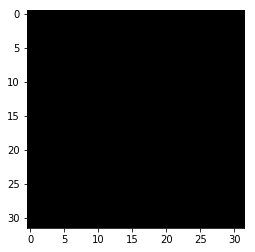

(50, 32, 32, 16, 1)


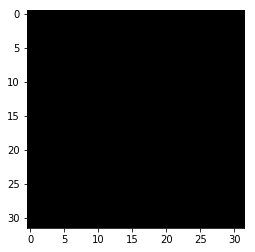

In [26]:

plt.imshow(trainfg[15, :, :, 5, 0]*255, cmap='gray')
plt.show()
plt.imshow(labelsfg[15, :, :, 5, 1], cmap = 'gray')
print(train.shape)

In [27]:
def step_decay(epoch):
    initial_lrate = 10e-4
    drop = 0.1
    epochs_drop = 25
    rate = initial_lrate
    if epoch == 25:
        lrate = initial_lrate * math.pow(drop,  
        np.floor((1+epoch)/epochs_drop))
        rate = lrate
    else: lrate = rate
    return lrate
lrate = LearningRateScheduler(step_decay)

callback_list = [lrate]

In [28]:

model_simple = vnet()
model_simple.summary(line_length=113)
model_simple.compile(optimizer=SGD(lr=1e-4, momentum=0.99), loss=dice_coef_loss2, metrics=[dice_coe])

layer 2 - soma  (?, 16, 16, 8, 32)
layer 2 - activ  (?, 8, 8, 4, 64)
(?, 8, 8, 4, 64)
(?, 8, 8, 4, 64)
(?, 8, 8, 4, 64)
(?, 8, 8, 4, 64)
layer 3 - soma  (?, 8, 8, 4, 64)
layer 3 - activ  (?, 4, 4, 2, 128)
(?, 4, 4, 2, 128)
(?, 4, 4, 2, 128)
(?, 4, 4, 2, 128)
(?, 4, 4, 2, 128)
layer 4 - soma  (?, 4, 4, 2, 128)
layer 4 - activ  (?, 2, 2, 1, 256)
layer 5 - soma  (?, 2, 2, 1, 256)
layer 5 - activ  (?, 4, 4, 2, 128)
(?, 4, 4, 2, 256)
(?, 4, 4, 2, 256)
(?, 4, 4, 2, 256)
(?, 4, 4, 2, 256)
(?, 4, 4, 2, 256)
(?, 8, 8, 4, 128)
(?, 8, 8, 4, 128)
(?, 8, 8, 4, 128)
(?, 8, 8, 4, 128)
_________________________________________________________________________________________________________________
Layer (type)                         Output Shape             Param #      Connected to                          
data (InputLayer)                    (None, 32, 32, 16, 1)    0                                                  
_________________________________________________________________________________

In [29]:
history = model_simple.fit(train, labels, epochs= 20, batch_size = 2, verbose=1, callbacks=callback_list)


Epoch 1/20
14/50 [=======>......................] - ETA: 3:02 - loss: 0.5866 - dice_coe: 0.4134

KeyboardInterrupt: 

0.0


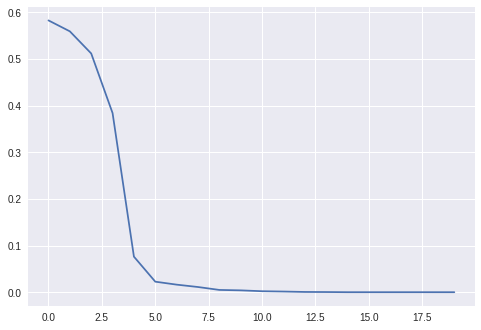

In [88]:
plt.plot(np.arange(len(history.history['loss'])), history.history['loss'])
print(np.min(labels))

0.0 1.0


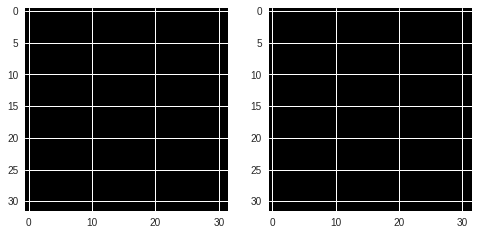

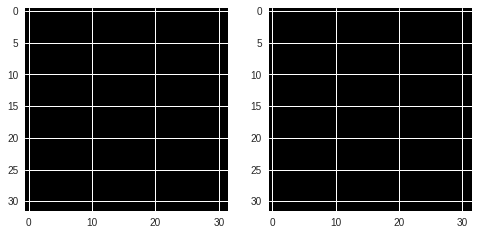

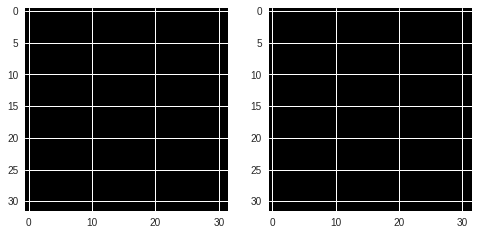

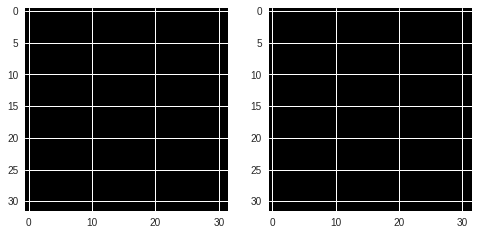

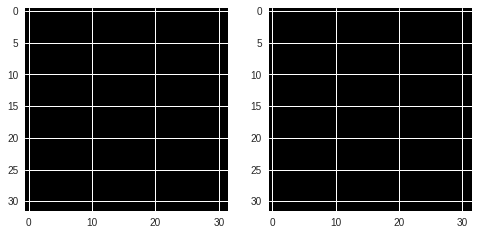

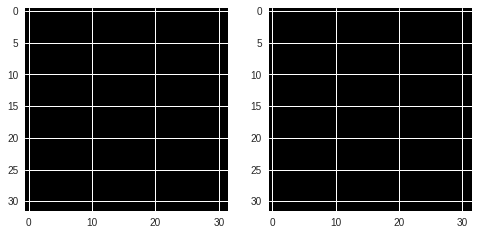

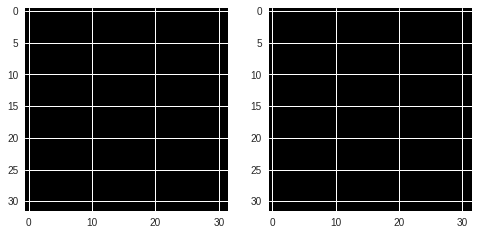

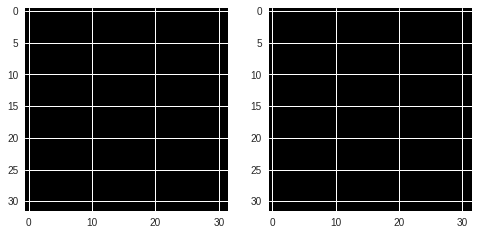

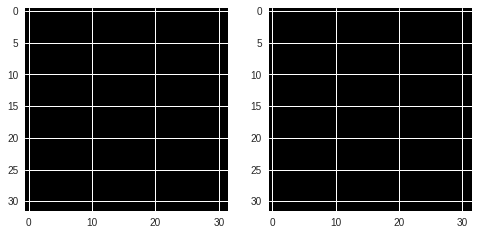

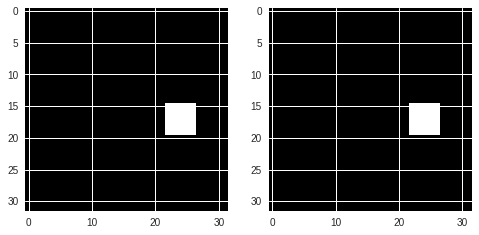

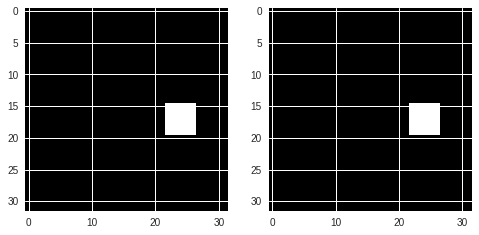

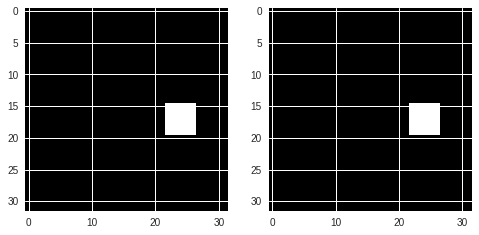

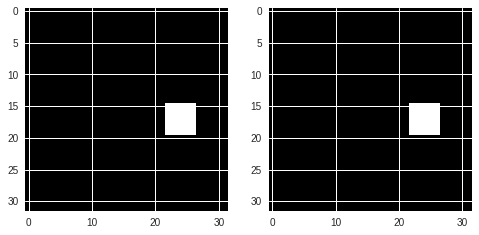

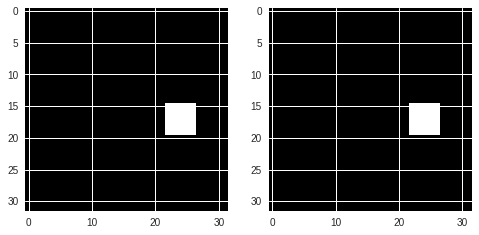

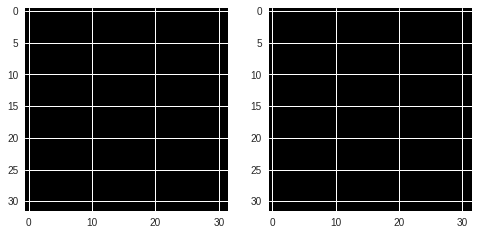

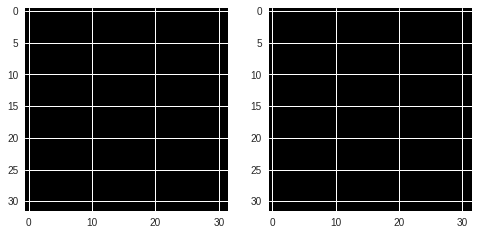

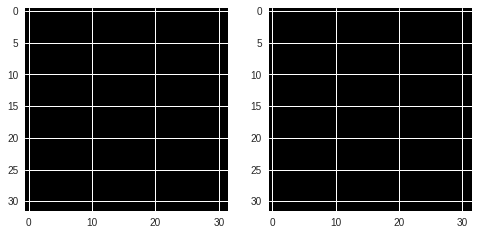

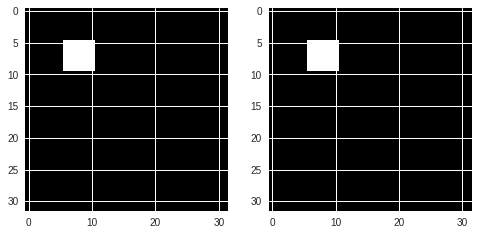

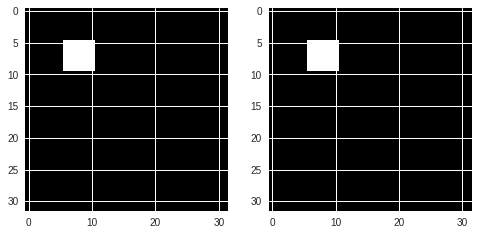

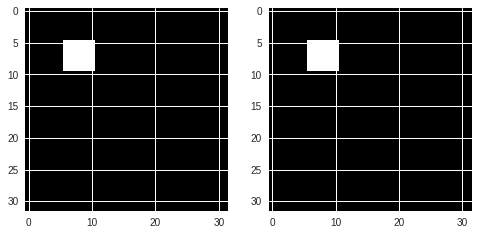

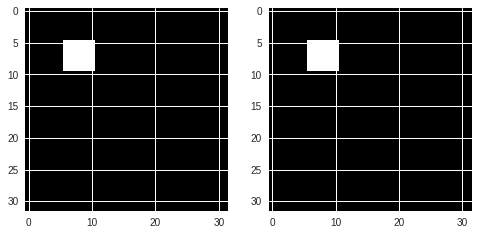

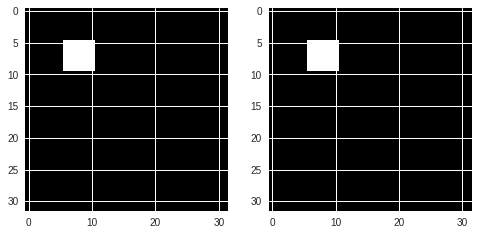

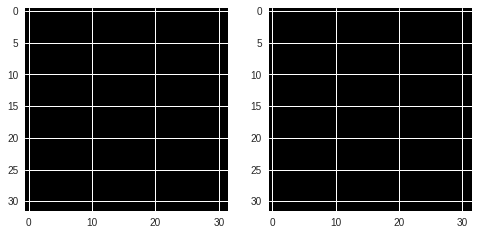

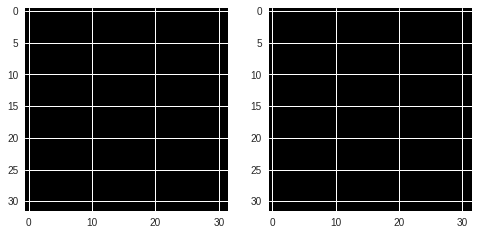

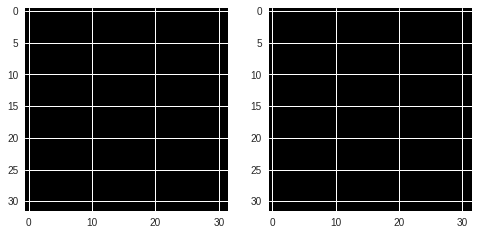

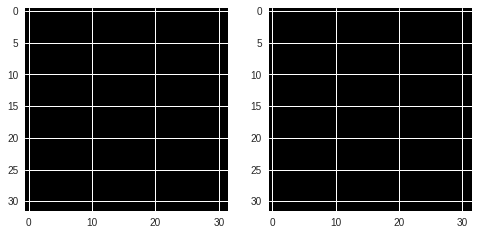

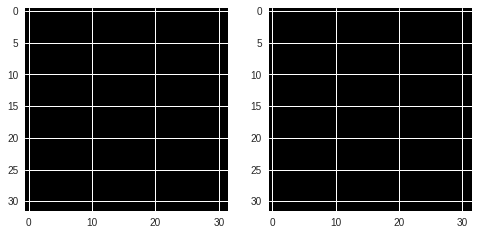

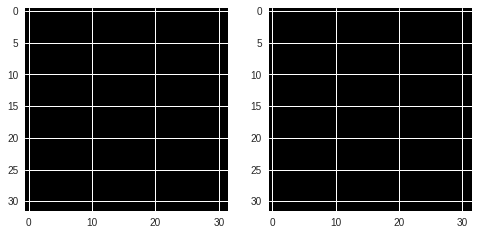

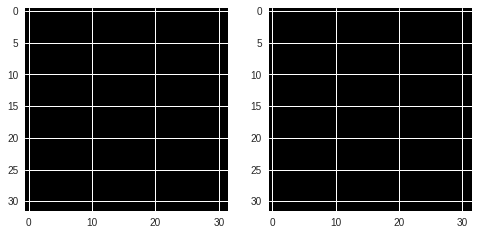

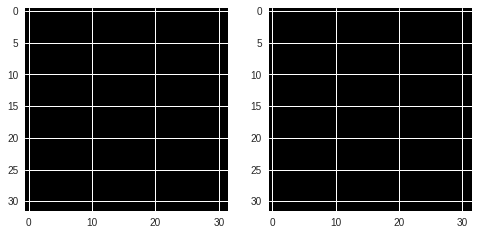

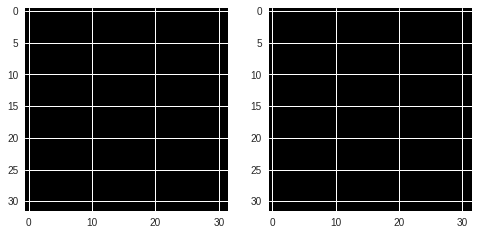

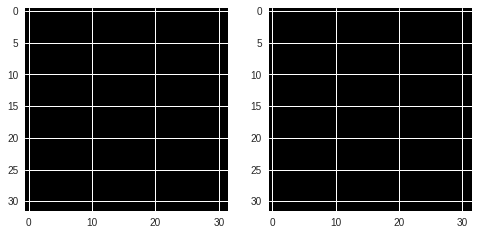

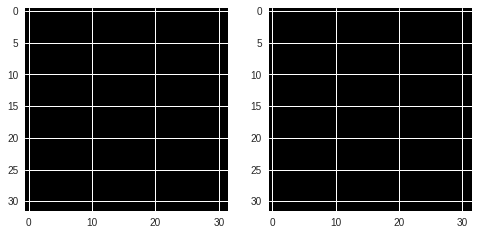

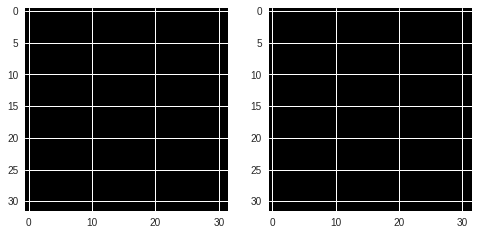

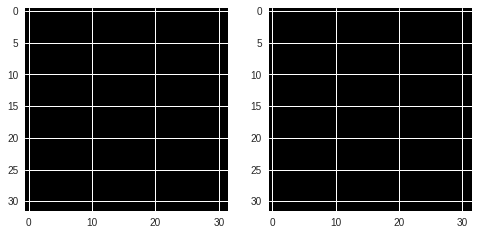

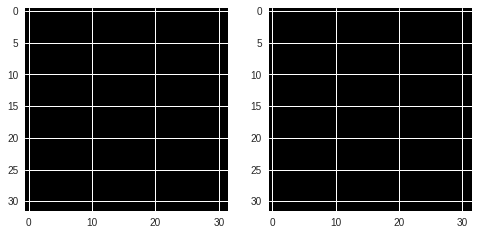

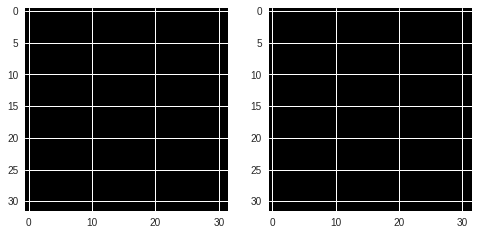

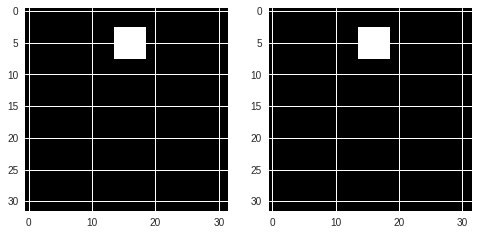

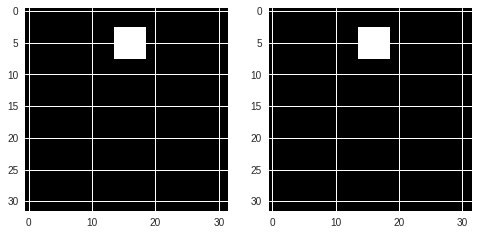

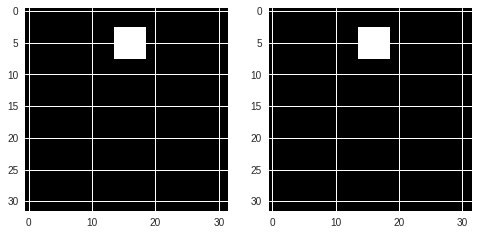

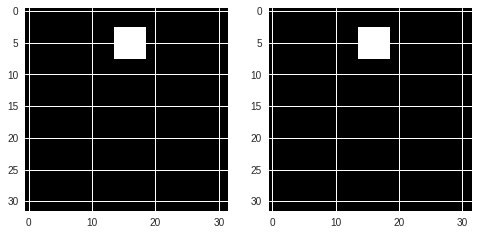

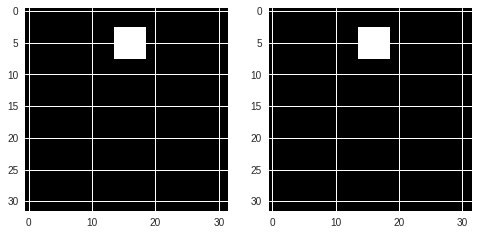

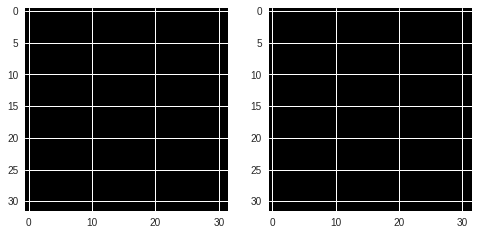

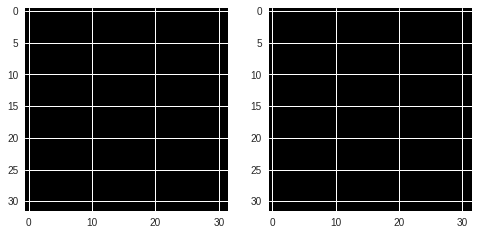

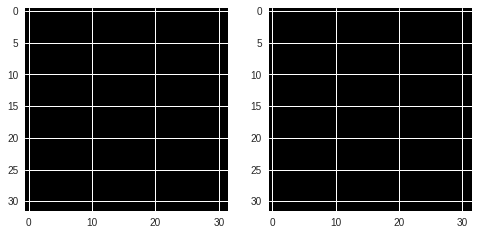

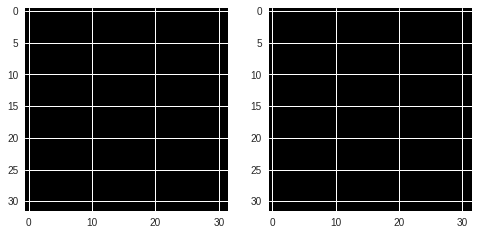

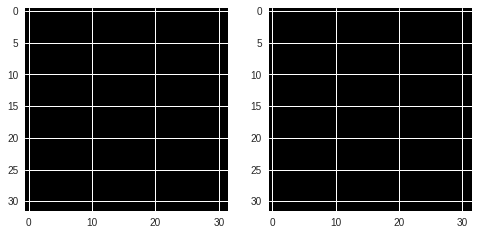

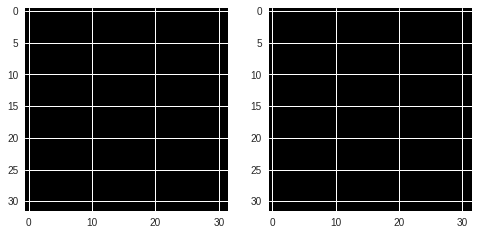

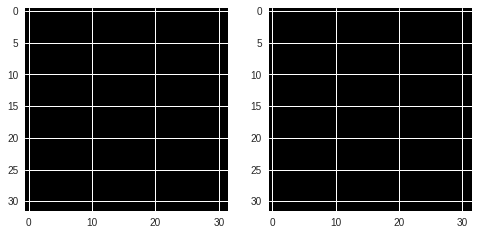

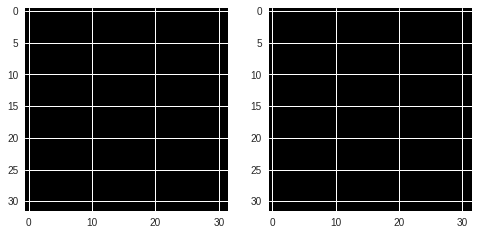

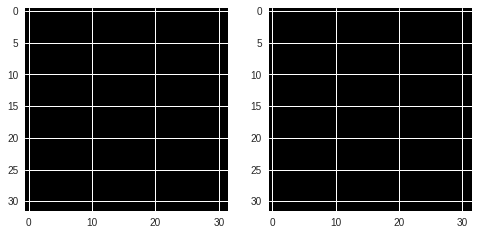

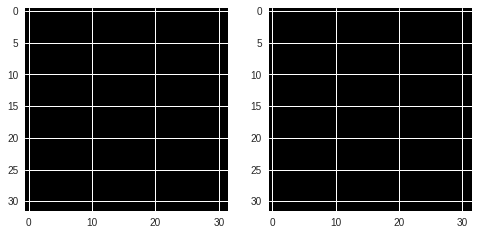

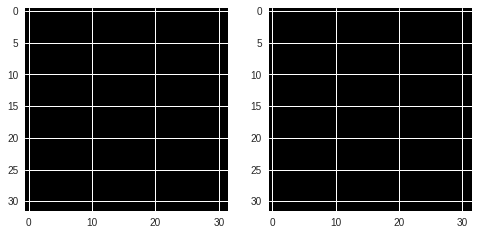

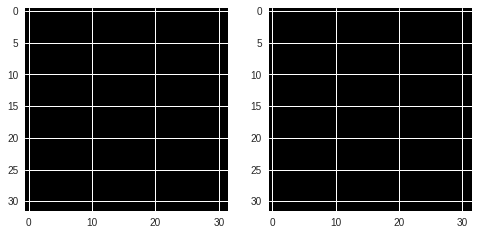

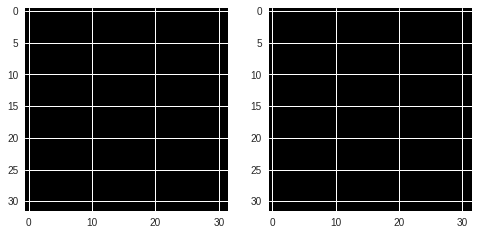

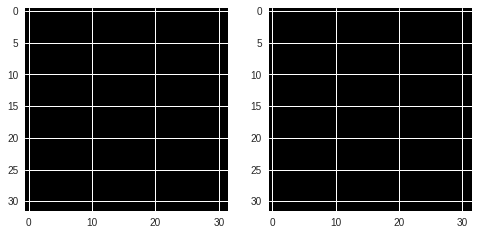

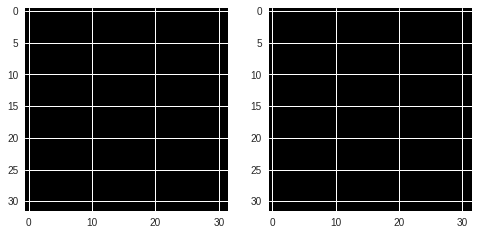

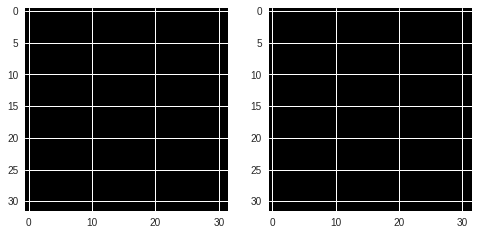

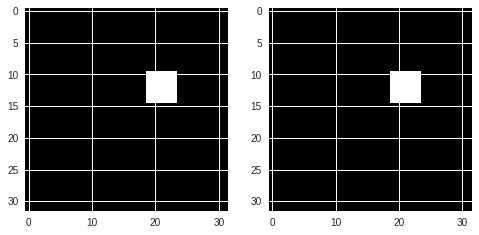

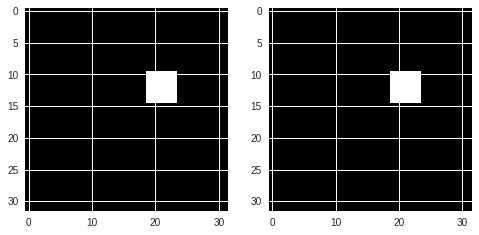

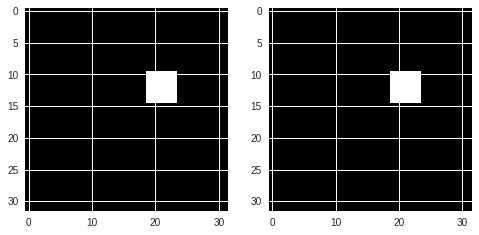

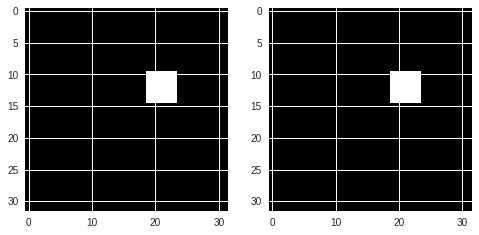

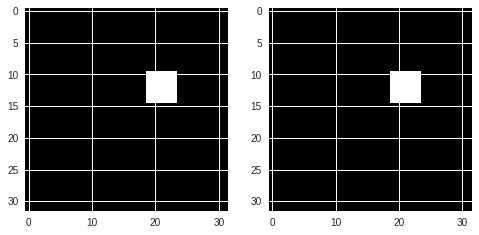

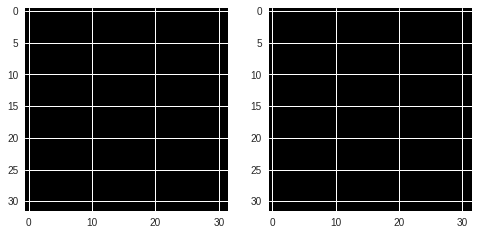

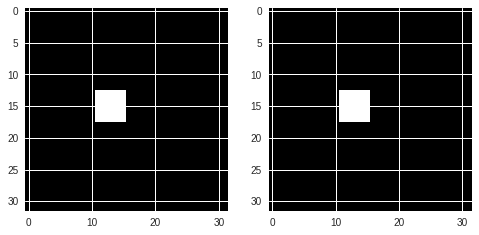

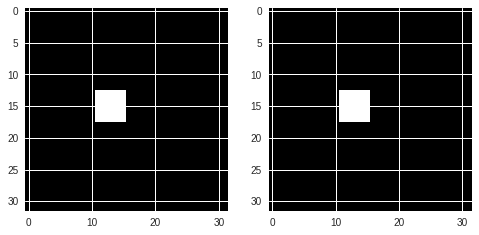

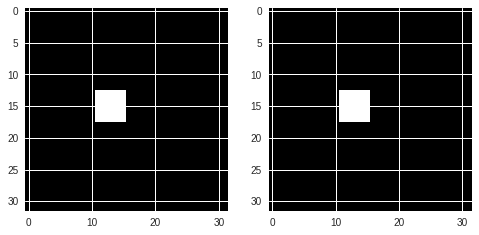

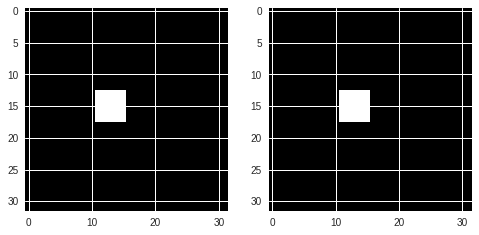

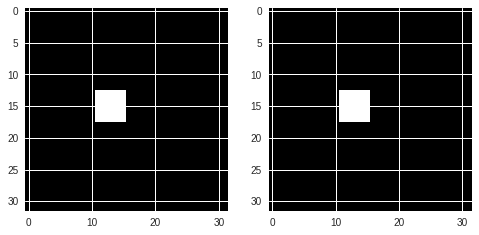

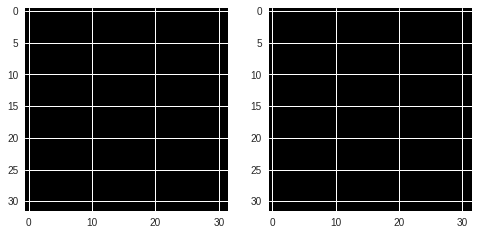

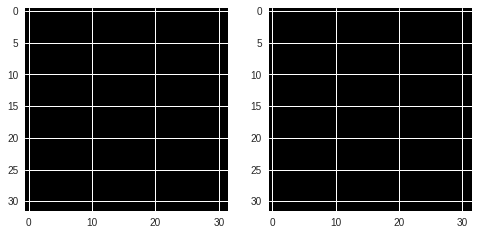

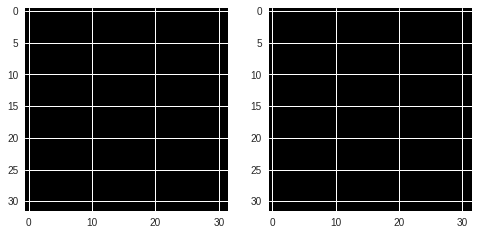

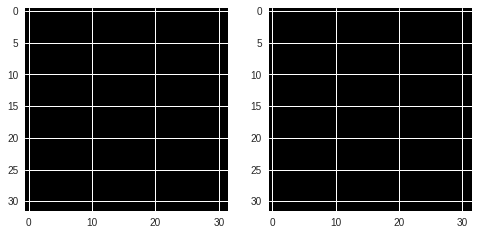

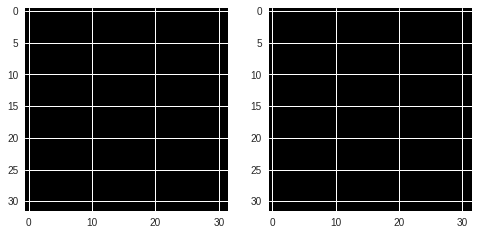

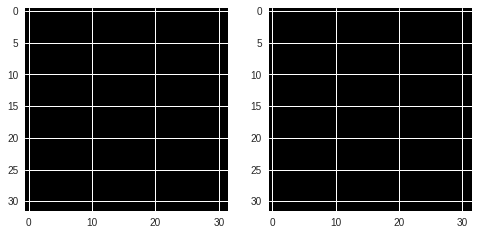

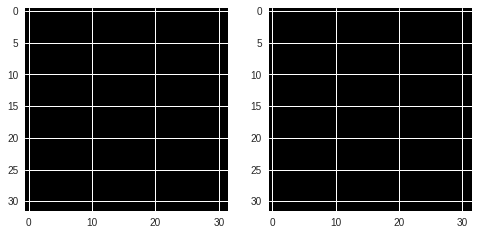

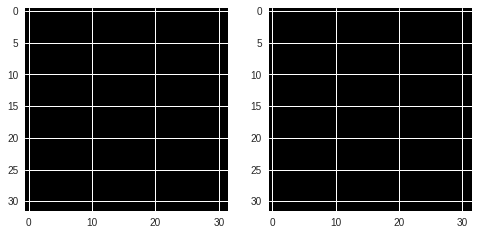

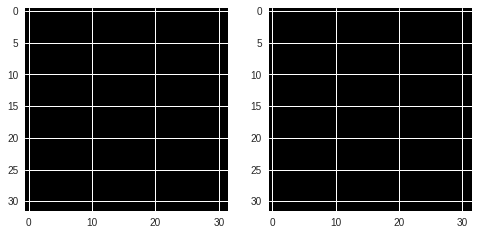

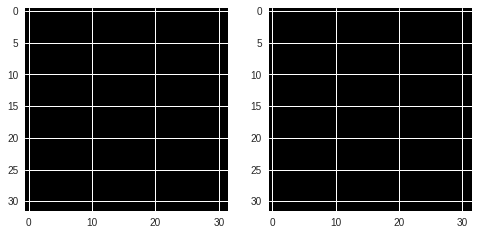

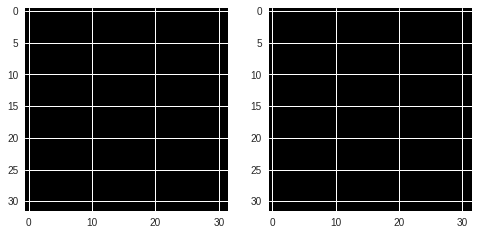

In [90]:
test, labeltest = gen_cubes_simple(n=5)
import tensorflow as tf
mean = 0
for j in range(5):
  pred = model_simple.predict(test[None, j, :, : :] )
  #mean+=tf.Session().run(dice_coe((pred>0.5).astype('float32'), labeltest[0]))
  for i in range(16):
      plt.subplot(1, 2, 1)
      plt.imshow(pred[0, :, :, i, 0] > 0.5,  cmap = 'gray')
      plt.subplot(1, 2, 2)
      plt.imshow(labeltest[j, :, :, i, 0], cmap = 'gray')
      plt.show()

In [103]:

model_noisefg = vnet()
model_noisefg.compile(optimizer=SGD(lr=1e-4, momentum=0.99), loss=dice_coef_loss2, metrics=[dice_coe])
historyfg = model_noisefg.fit(trainfg, labelsfg, epochs= 40, batch_size = 2, verbose=1, callbacks=callback_list)

layer 2 - soma  (?, 16, 16, 8, 32)
layer 2 - activ  (?, 8, 8, 4, 64)
(?, 8, 8, 4, 64)
(?, 8, 8, 4, 64)
(?, 8, 8, 4, 64)
(?, 8, 8, 4, 64)
layer 3 - soma  (?, 8, 8, 4, 64)
layer 3 - activ  (?, 4, 4, 2, 128)
(?, 4, 4, 2, 128)
(?, 4, 4, 2, 128)
(?, 4, 4, 2, 128)
(?, 4, 4, 2, 128)
layer 4 - soma  (?, 4, 4, 2, 128)
layer 4 - activ  (?, 2, 2, 1, 256)
layer 5 - soma  (?, 2, 2, 1, 256)
layer 5 - activ  (?, 4, 4, 2, 128)
(?, 4, 4, 2, 256)
(?, 4, 4, 2, 256)
(?, 4, 4, 2, 256)
(?, 4, 4, 2, 256)
(?, 4, 4, 2, 256)
(?, 8, 8, 4, 128)
(?, 8, 8, 4, 128)
(?, 8, 8, 4, 128)
(?, 8, 8, 4, 128)
Epoch 1/20
50/50 [==============================] - 19s 386ms/step - loss: 0.5862 - dice_coe: 0.4138
Epoch 2/20
50/50 [==============================] - 9s 175ms/step - loss: 0.5750 - dice_coe: 0.4250
Epoch 3/20
50/50 [==============================] - 9s 175ms/step - loss: 0.5526 - dice_coe: 0.4474
Epoch 4/20
50/50 [==============================] - 9s 175ms/step - loss: 0.5209 - dice_coe: 0.4791
Epoch 5/20
50/50 [====

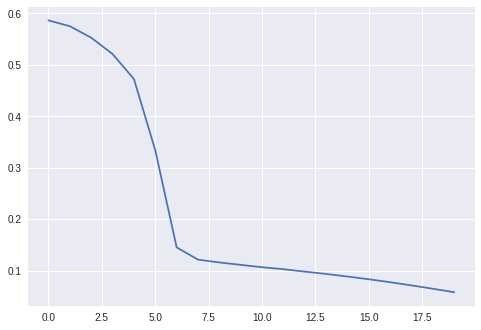

In [104]:
plt.plot(np.arange(len(historyfg.history['loss'])), historyfg.history['loss'])

0.0 1.0


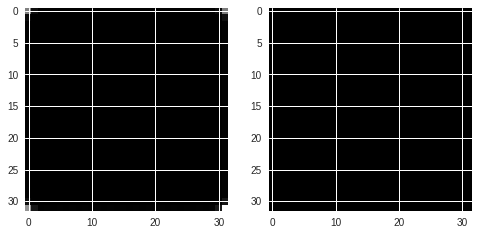

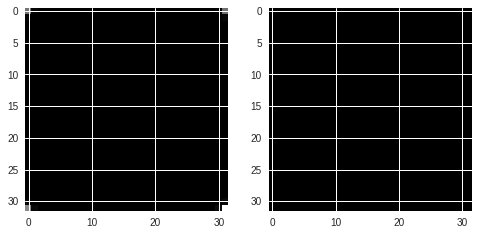

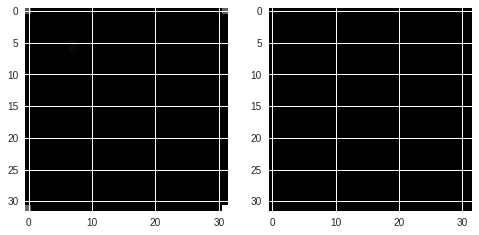

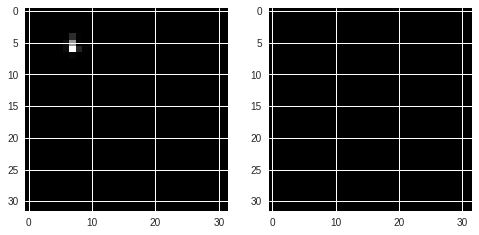

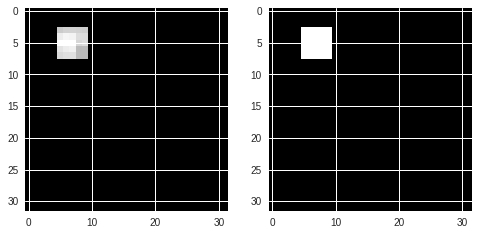

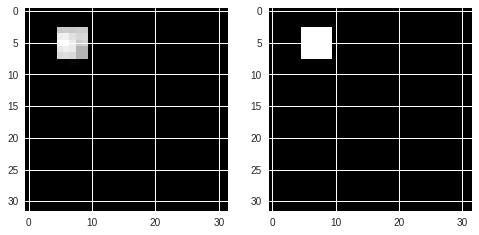

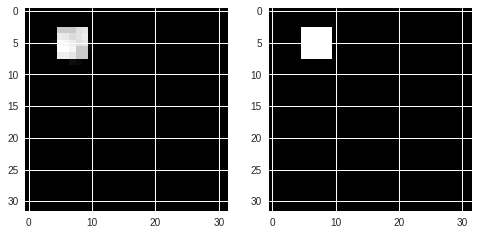

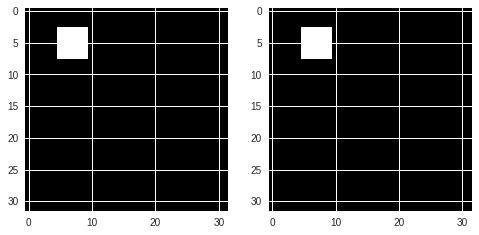

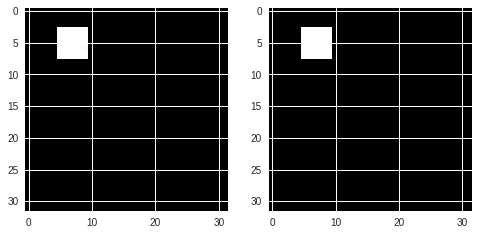

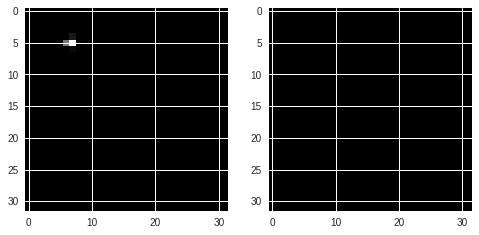

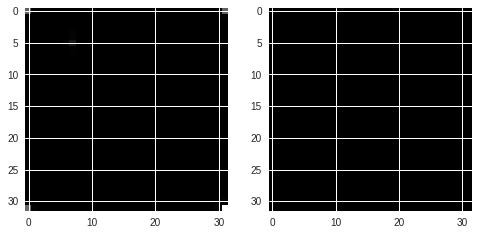

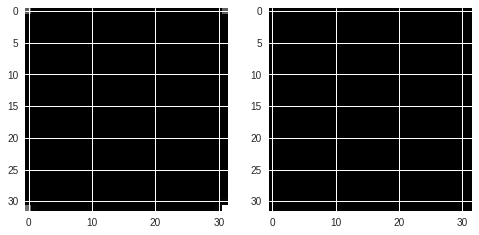

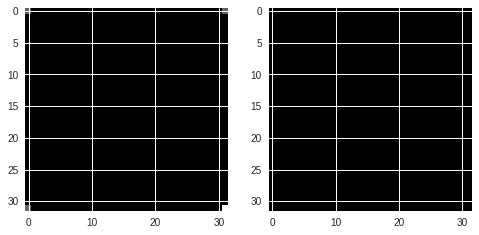

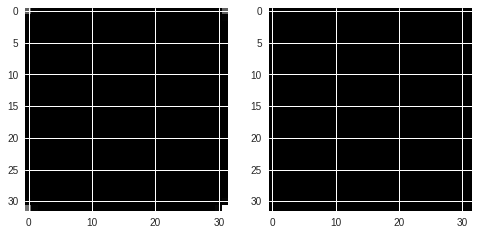

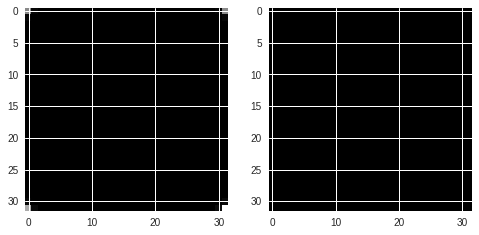

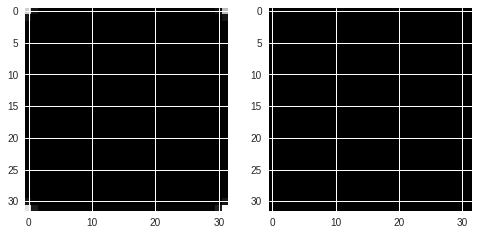

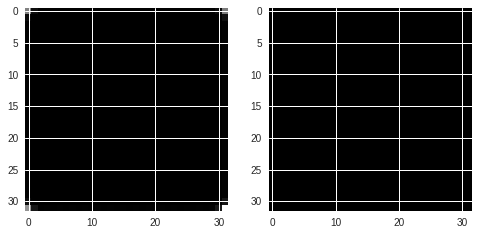

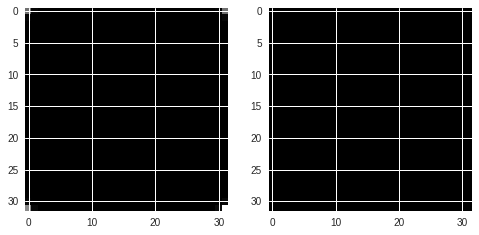

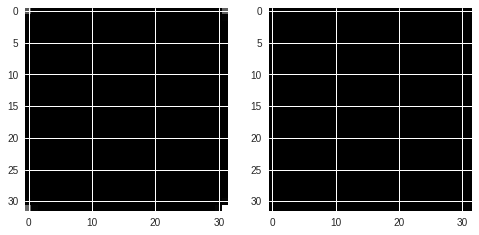

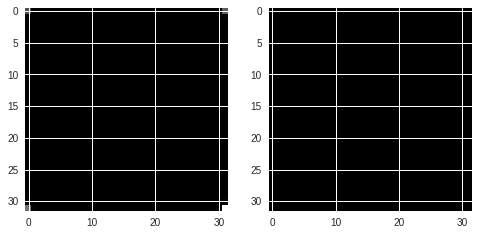

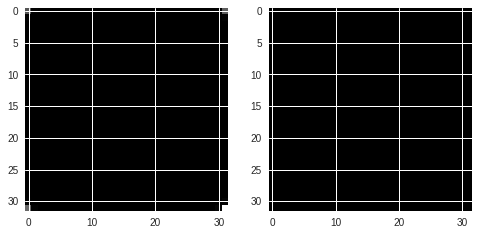

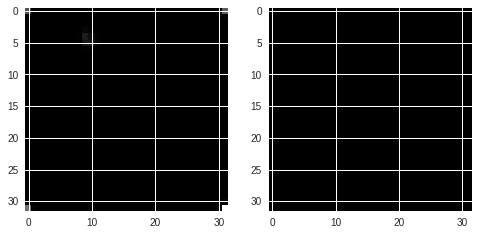

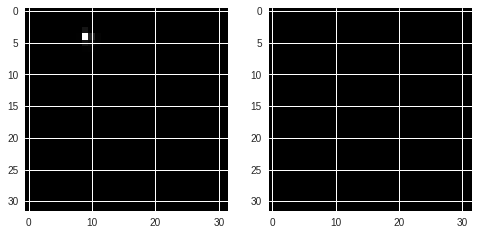

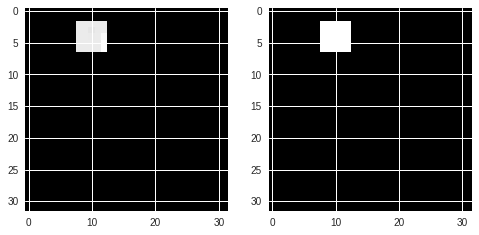

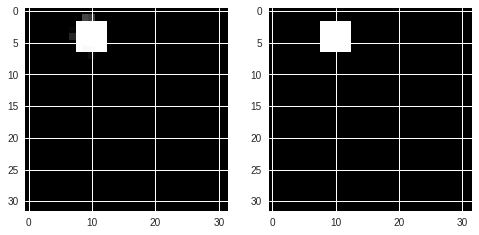

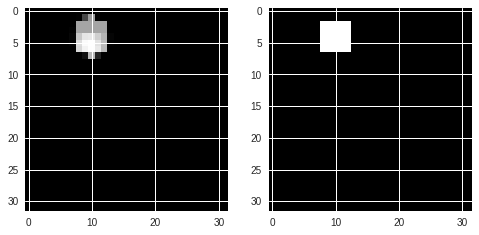

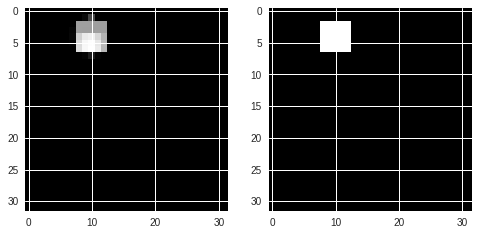

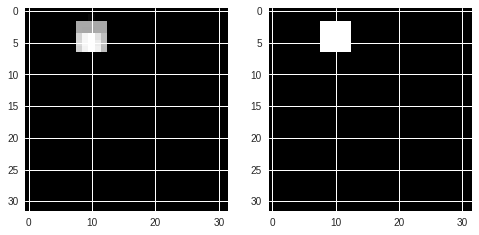

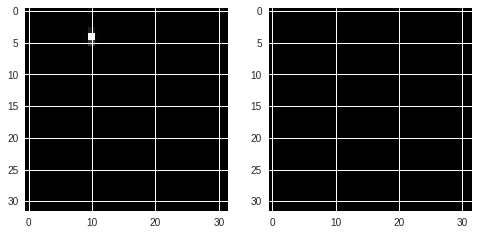

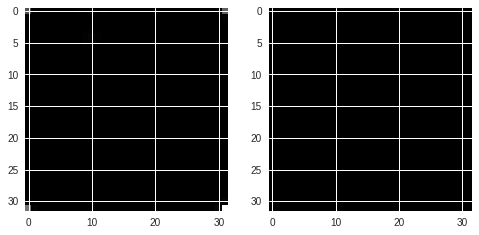

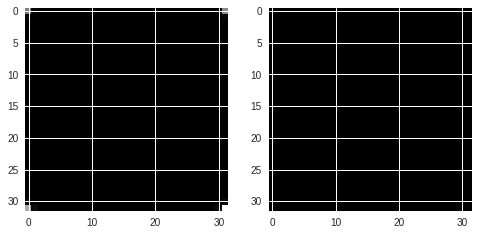

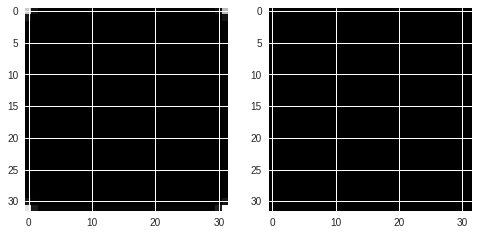

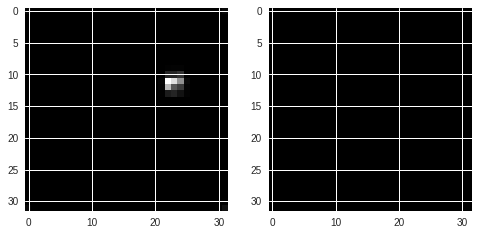

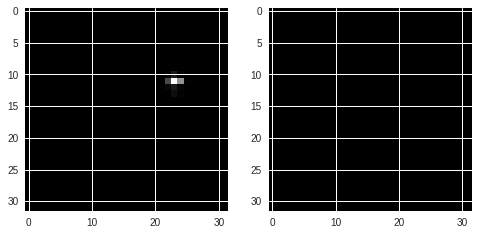

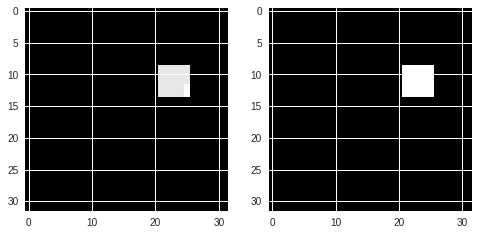

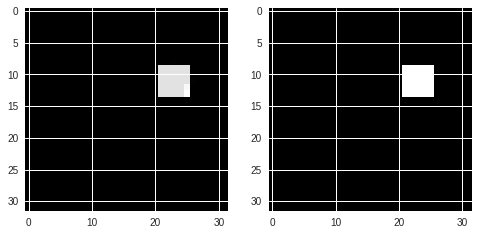

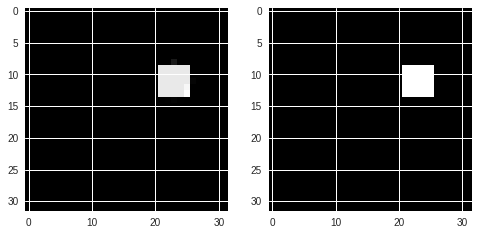

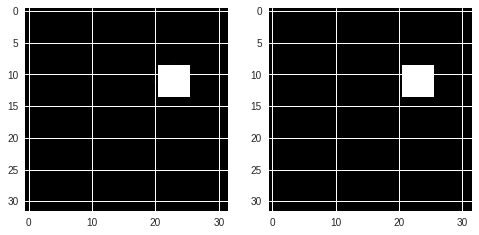

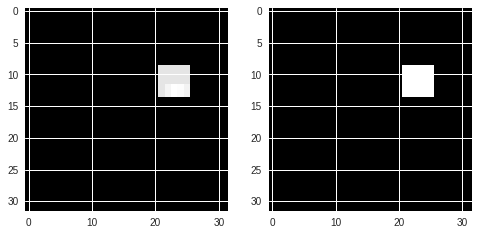

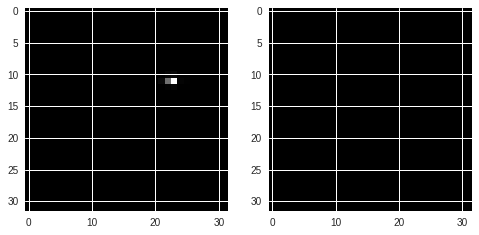

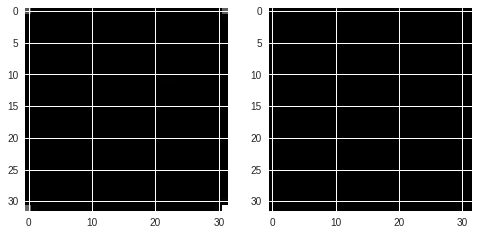

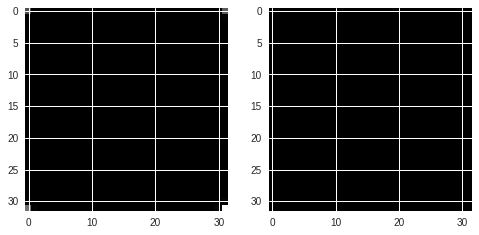

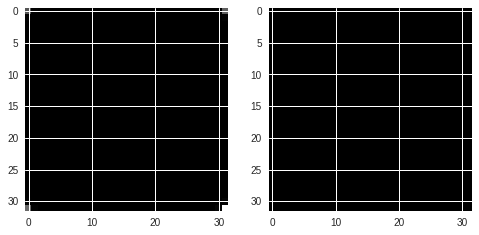

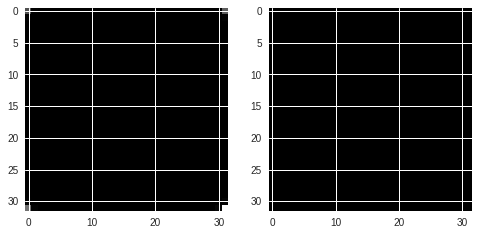

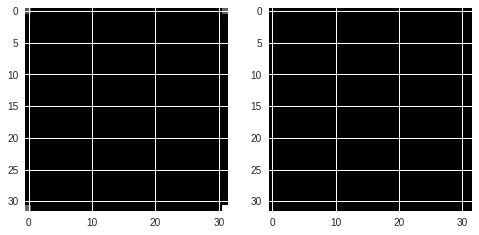

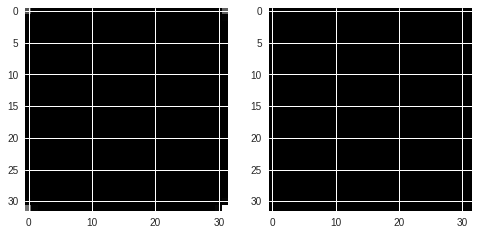

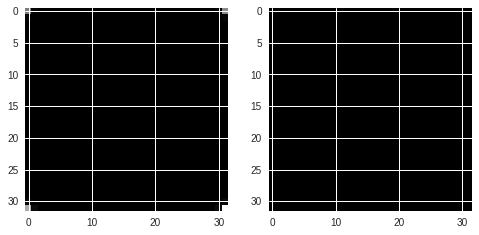

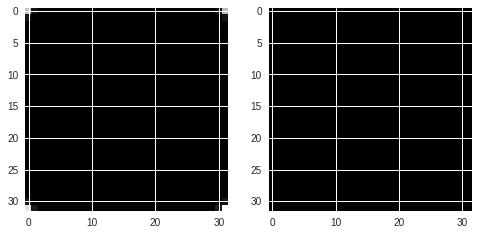

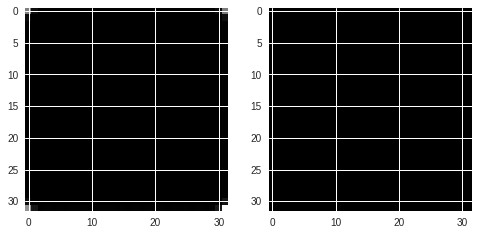

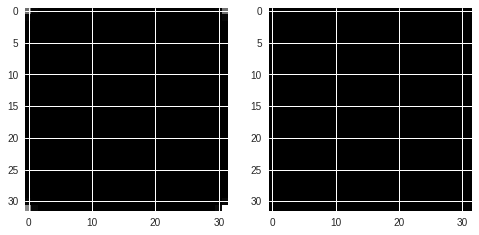

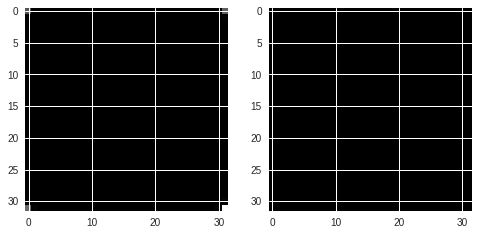

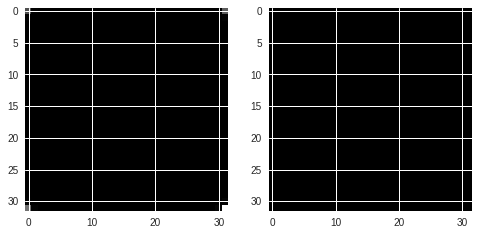

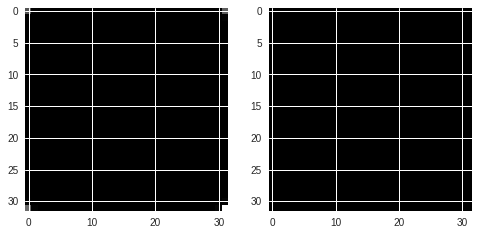

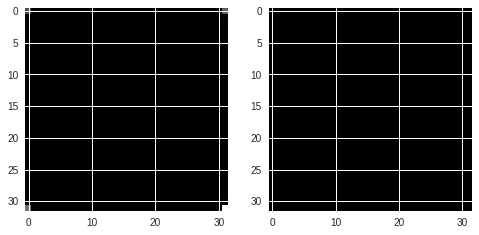

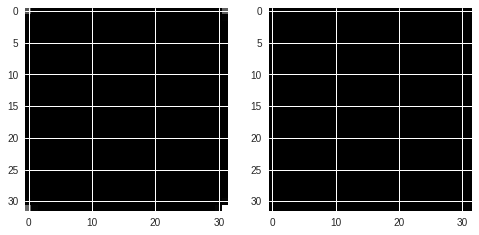

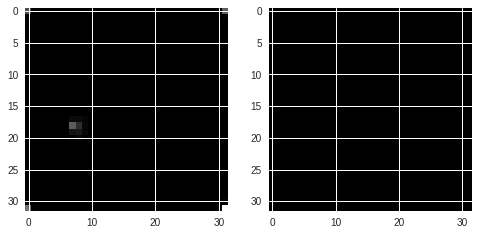

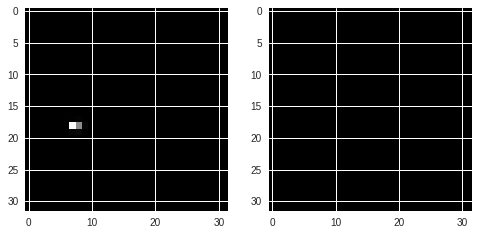

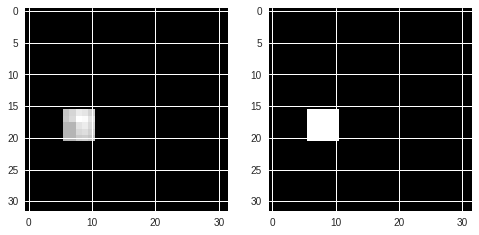

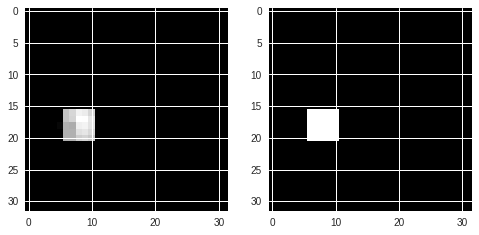

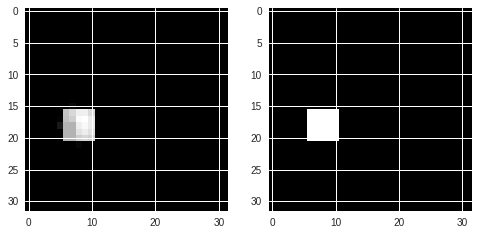

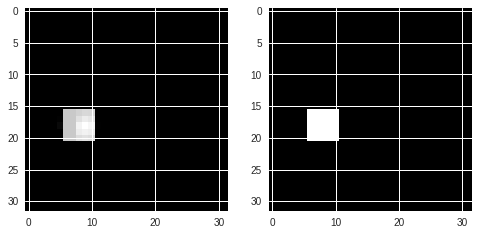

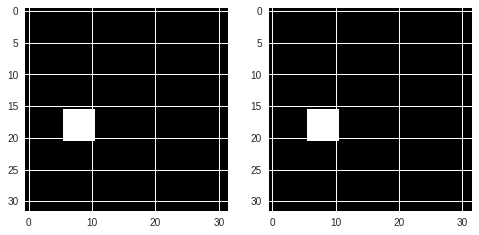

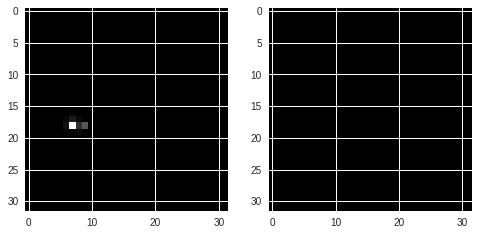

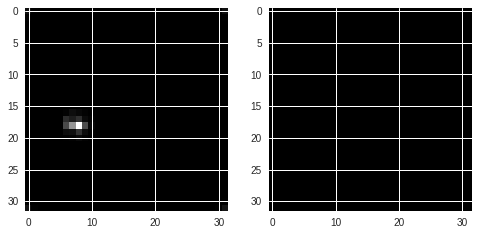

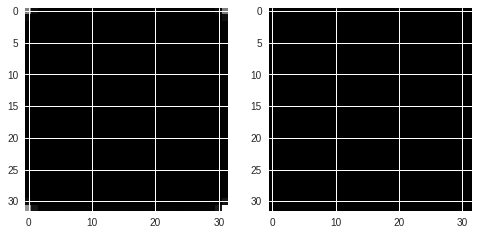

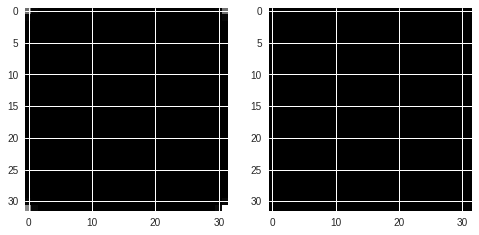

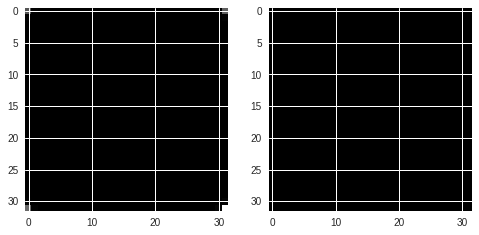

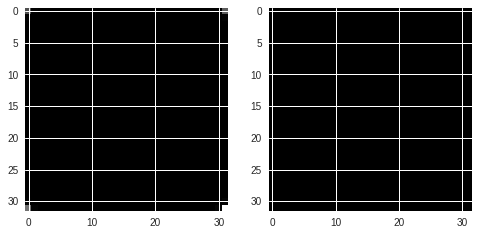

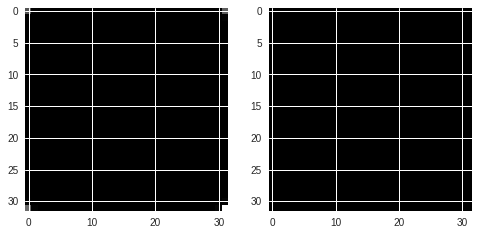

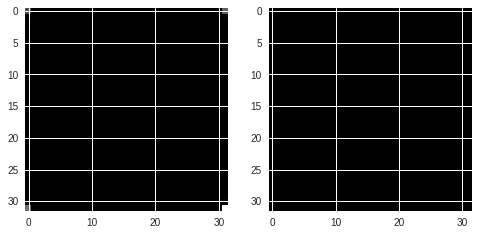

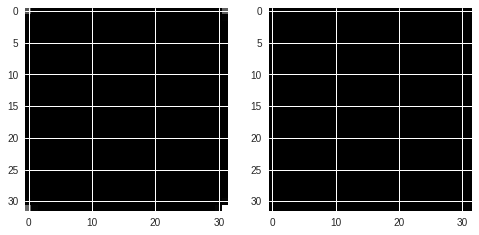

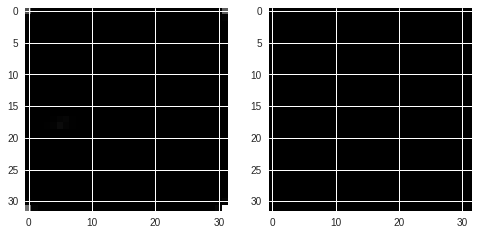

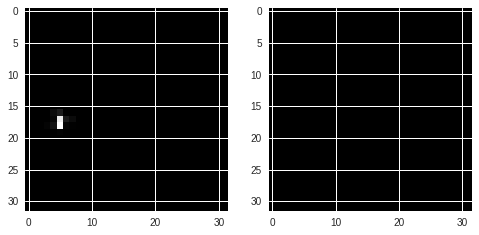

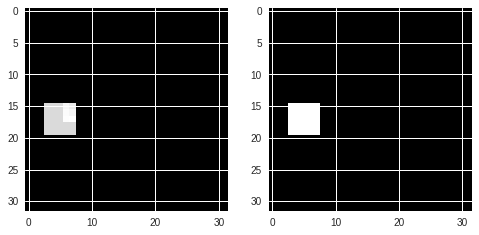

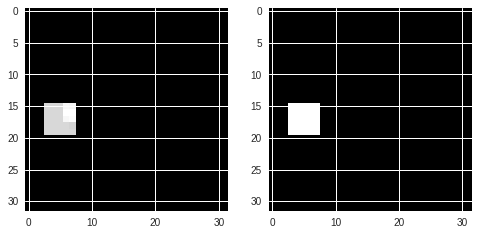

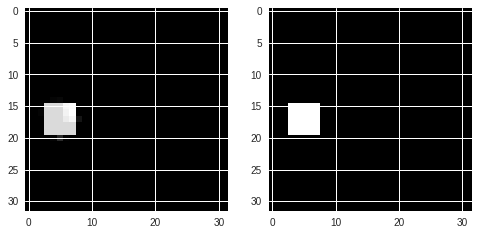

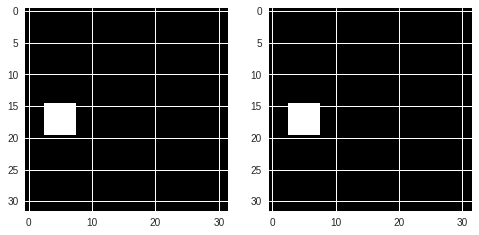

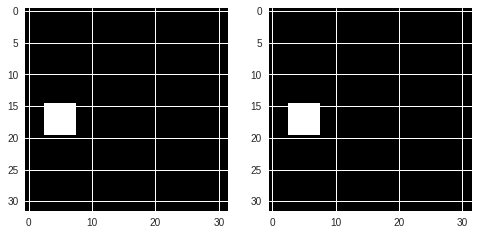

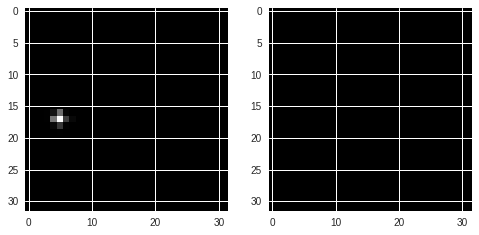

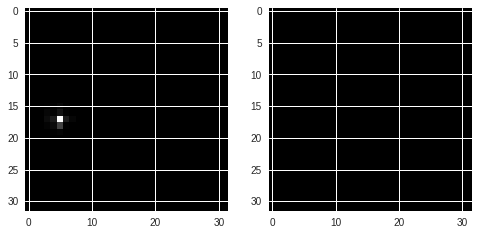

In [105]:
testfg, labeltestfg = gen_cubes_noisefg(n=5)
import tensorflow as tf
mean = 0
for j in range(5):
  predfg = model_noisefg.predict(testfg[None, j, :, : :] )
  #mean+=tf.Session().run(dice_coe((pred>0.5).astype('float32'), labeltest[0]))
  for i in range(16):
      plt.subplot(1, 2, 1)
      plt.imshow(predfg[0, :, :, i, 0],  cmap = 'gray')
      plt.subplot(1, 2, 2)
      plt.imshow(labeltestfg[j, :, :, i, 0], cmap = 'gray')
      plt.show()

In [106]:
model_noise = vnet()
model_noise.compile(optimizer=SGD(lr=1e-4, momentum=0.99), loss=dice_coef_loss2, metrics=[dice_coe])
history = model_noise.fit(train_noise, labels_noise, epochs= 20, batch_size = 2, verbose=1, callbacks=callback_list)

layer 2 - soma  (?, 16, 16, 8, 32)
layer 2 - activ  (?, 8, 8, 4, 64)
(?, 8, 8, 4, 64)
(?, 8, 8, 4, 64)
(?, 8, 8, 4, 64)
(?, 8, 8, 4, 64)
layer 3 - soma  (?, 8, 8, 4, 64)
layer 3 - activ  (?, 4, 4, 2, 128)
(?, 4, 4, 2, 128)
(?, 4, 4, 2, 128)
(?, 4, 4, 2, 128)
(?, 4, 4, 2, 128)
layer 4 - soma  (?, 4, 4, 2, 128)
layer 4 - activ  (?, 2, 2, 1, 256)
layer 5 - soma  (?, 2, 2, 1, 256)
layer 5 - activ  (?, 4, 4, 2, 128)
(?, 4, 4, 2, 256)
(?, 4, 4, 2, 256)
(?, 4, 4, 2, 256)
(?, 4, 4, 2, 256)
(?, 4, 4, 2, 256)
(?, 8, 8, 4, 128)
(?, 8, 8, 4, 128)
(?, 8, 8, 4, 128)
(?, 8, 8, 4, 128)
Epoch 1/20
50/50 [==============================] - 20s 401ms/step - loss: 0.5904 - dice_coe: 0.4096
Epoch 2/20
50/50 [==============================] - 9s 174ms/step - loss: 0.5749 - dice_coe: 0.4251
Epoch 3/20
50/50 [==============================] - 9s 174ms/step - loss: 0.5552 - dice_coe: 0.4448
Epoch 4/20
50/50 [==============================] - 9s 174ms/step - loss: 0.5321 - dice_coe: 0.4679
Epoch 5/20
50/50 [====

0.0 1.0


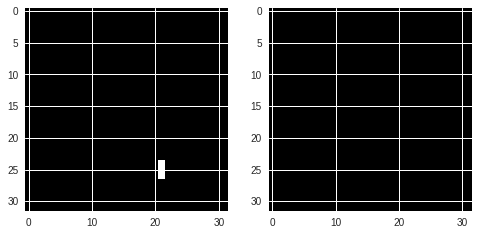

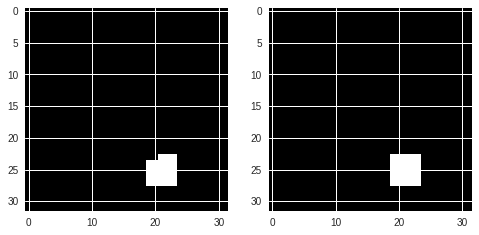

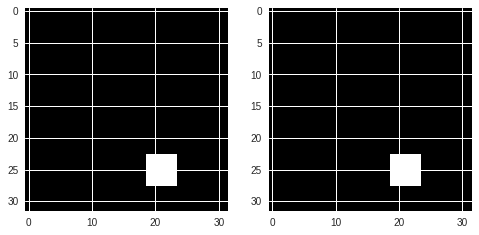

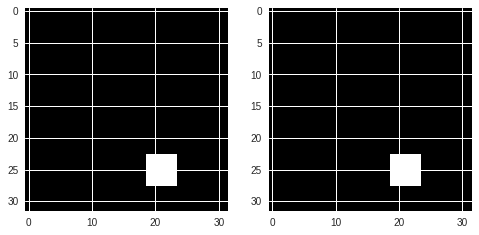

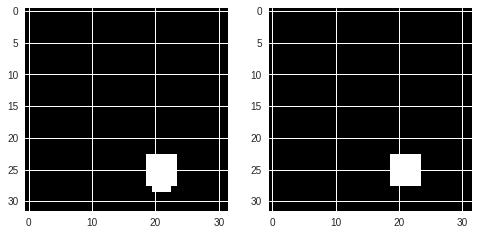

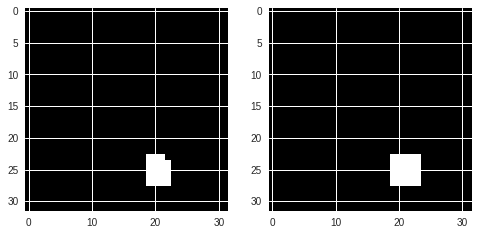

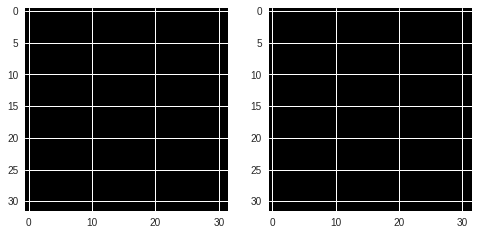

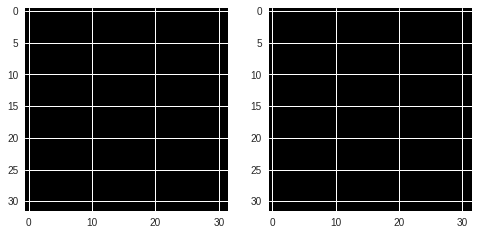

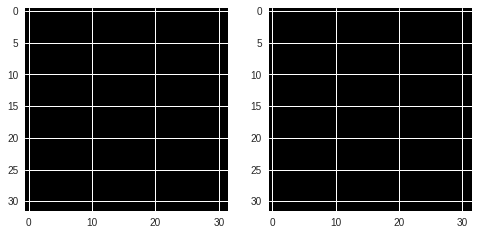

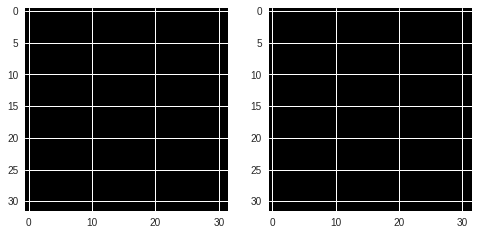

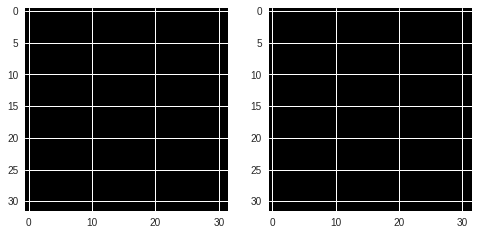

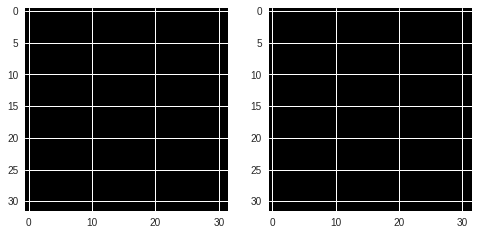

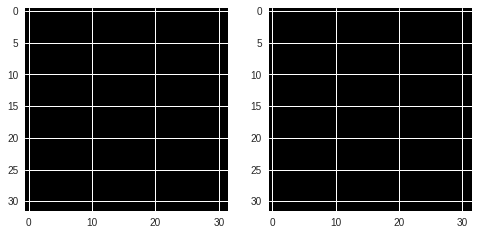

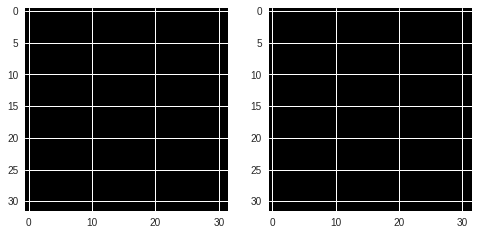

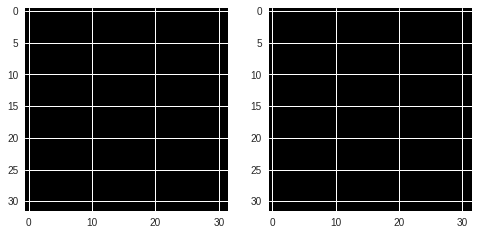

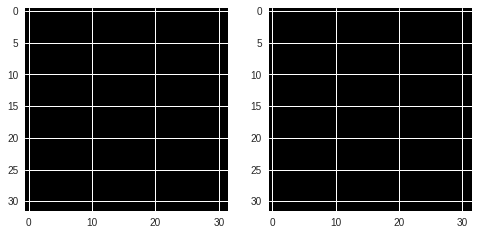

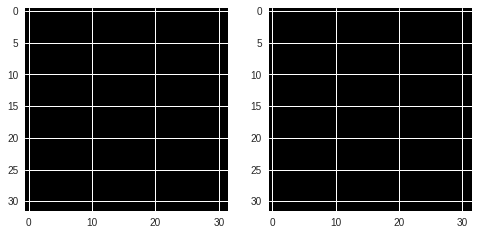

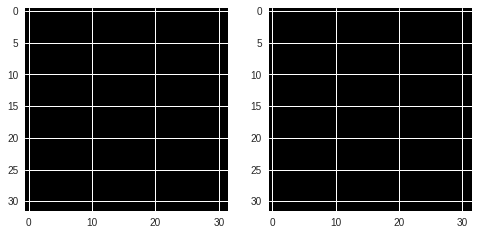

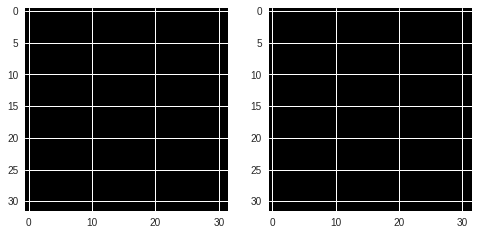

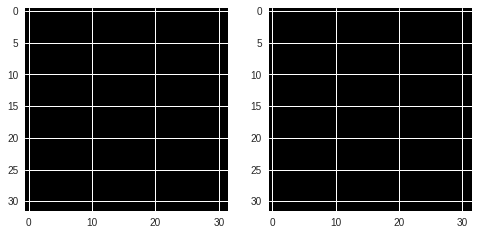

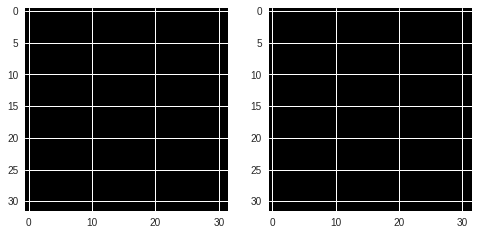

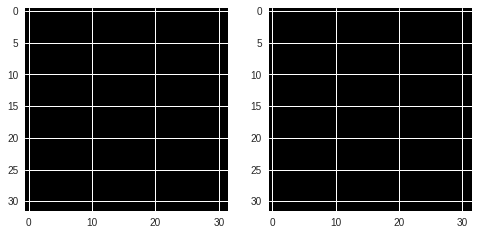

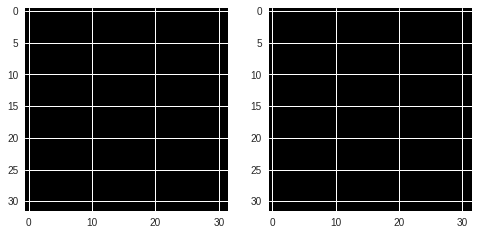

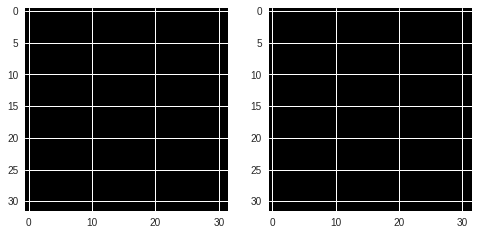

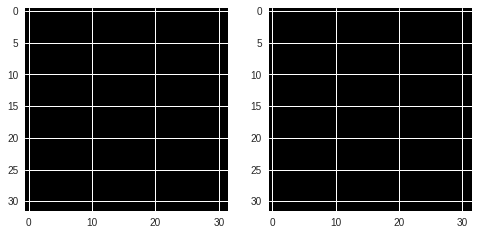

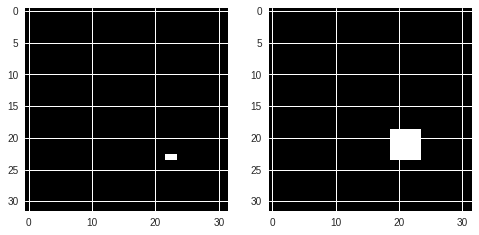

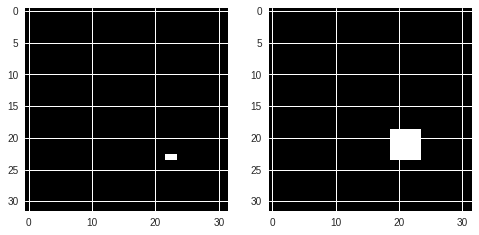

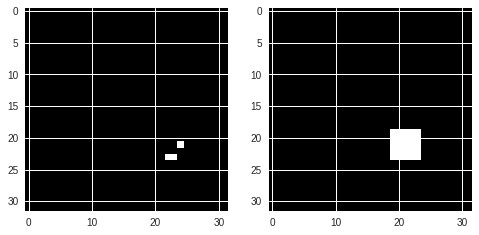

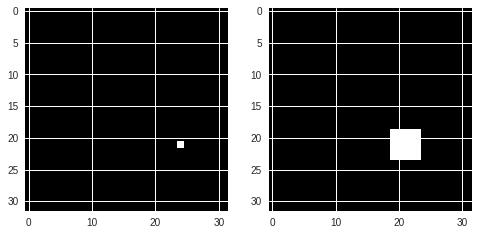

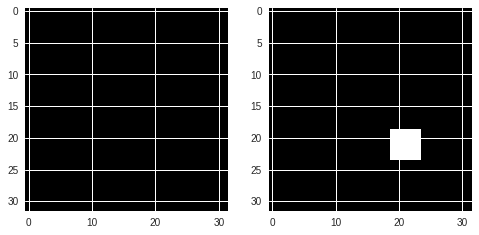

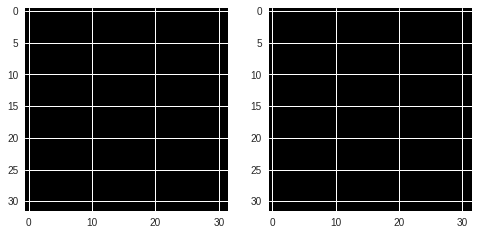

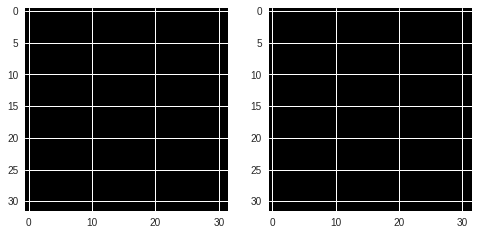

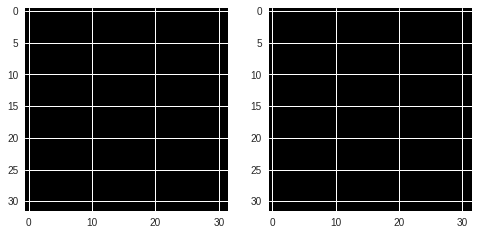

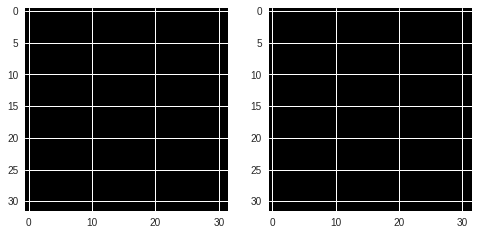

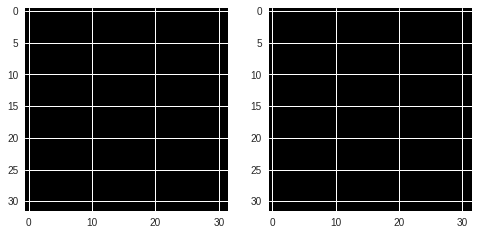

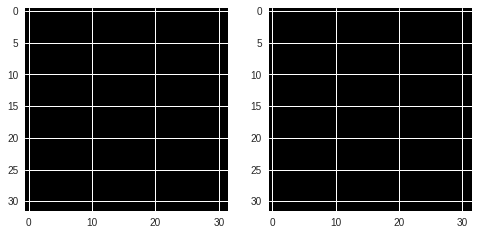

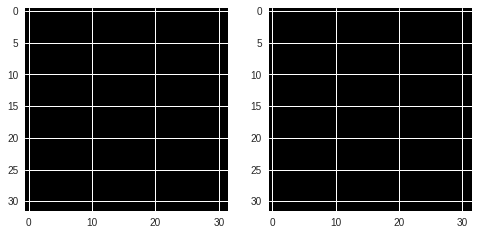

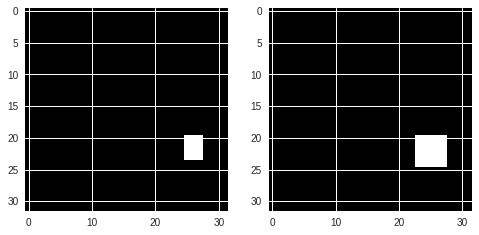

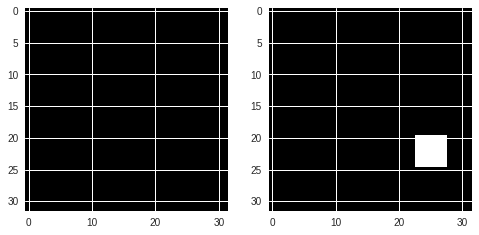

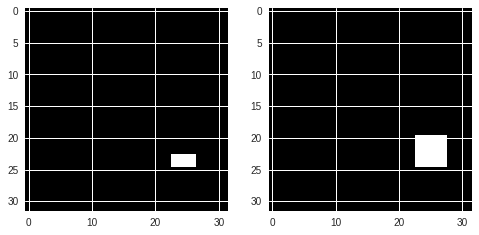

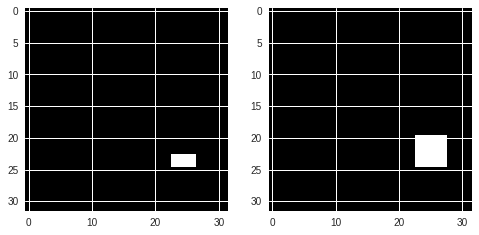

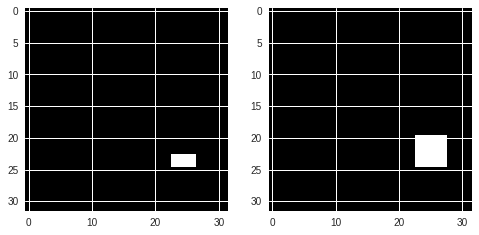

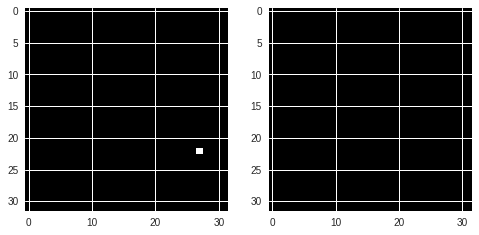

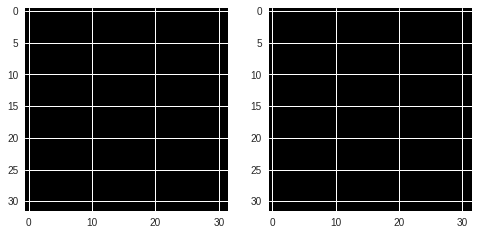

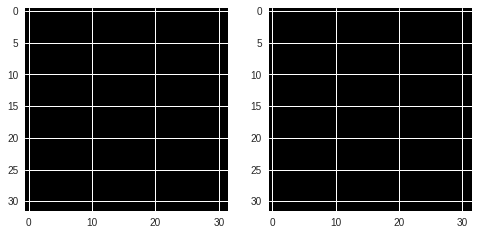

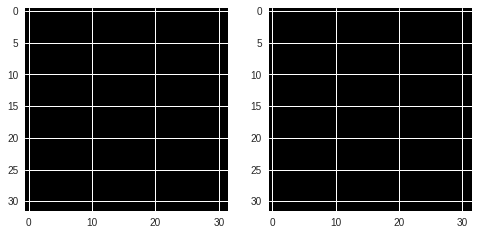

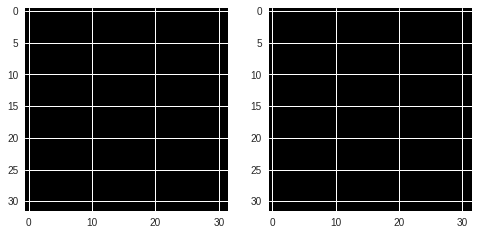

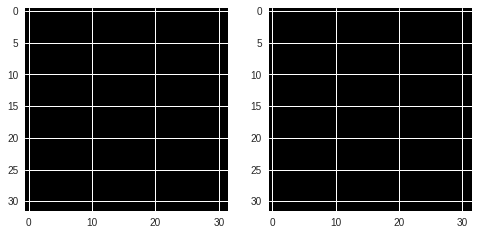

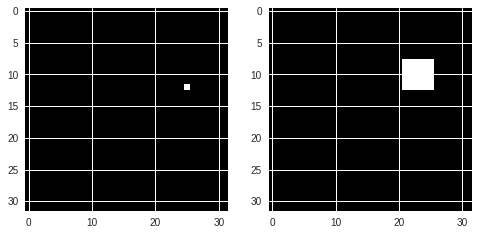

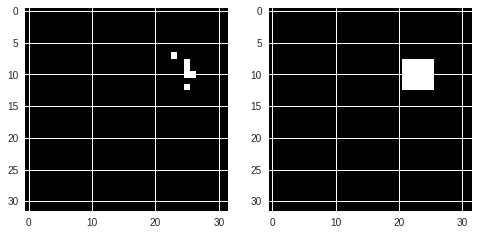

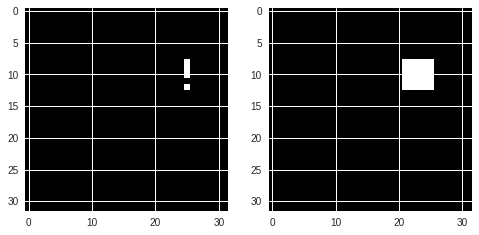

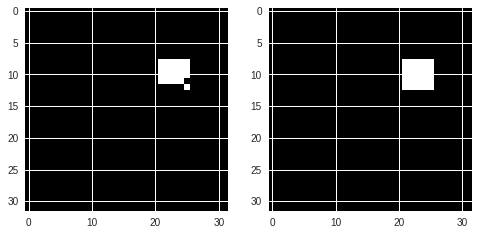

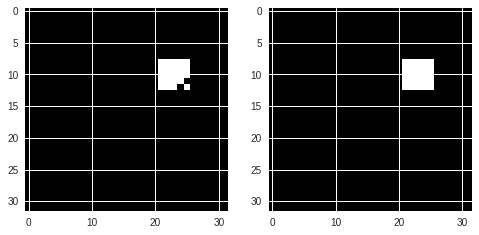

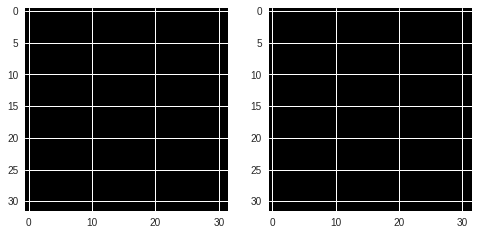

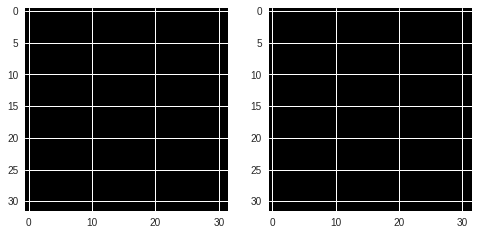

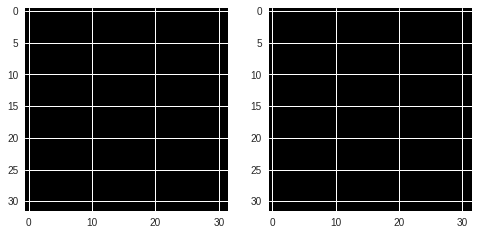

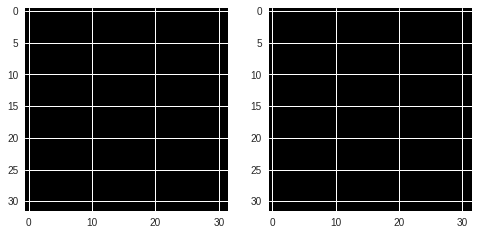

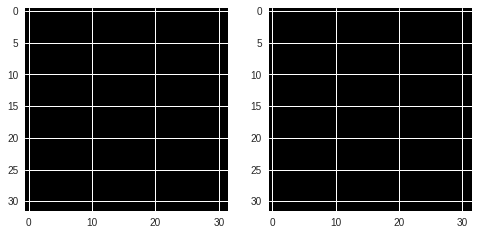

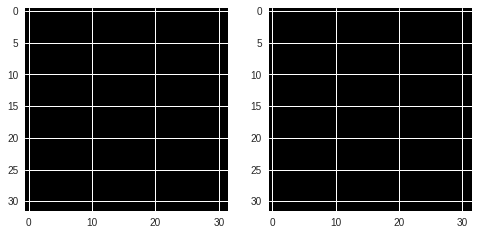

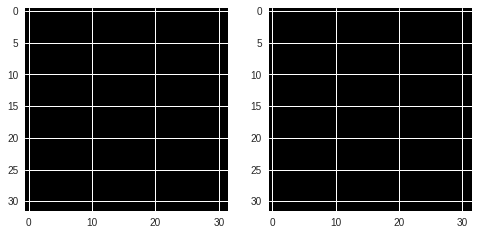

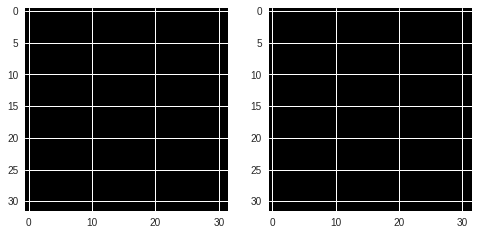

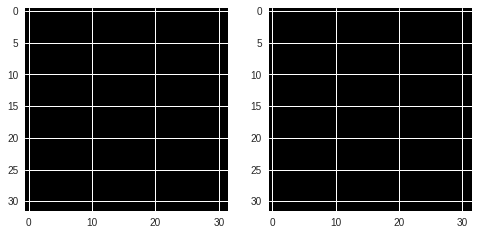

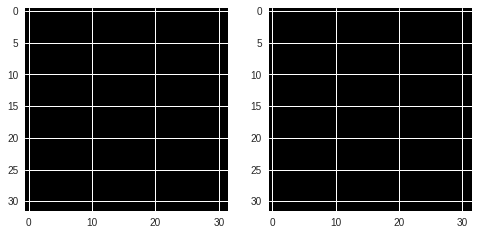

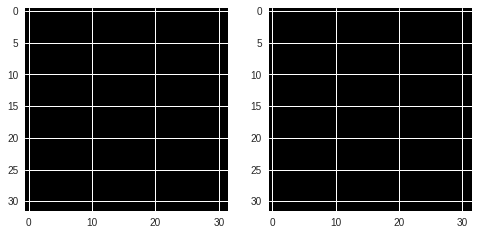

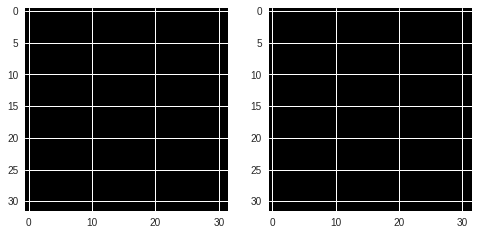

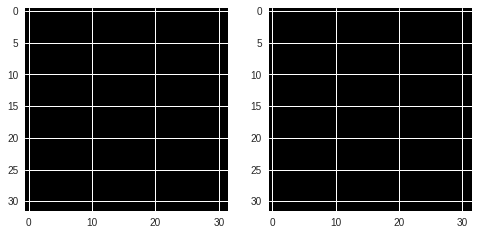

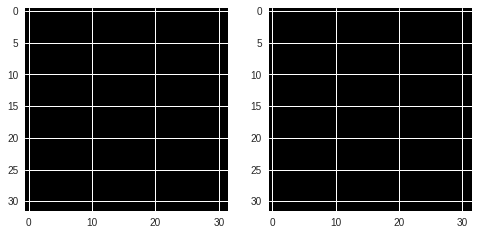

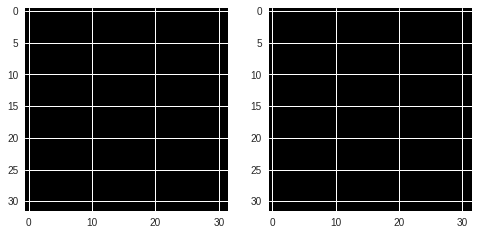

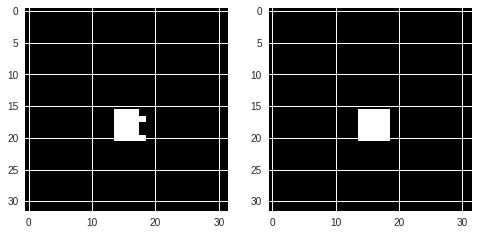

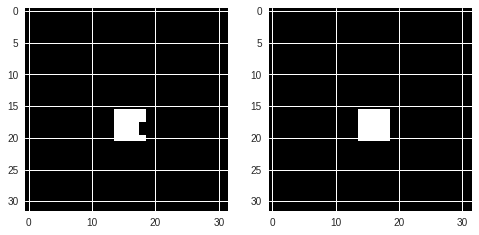

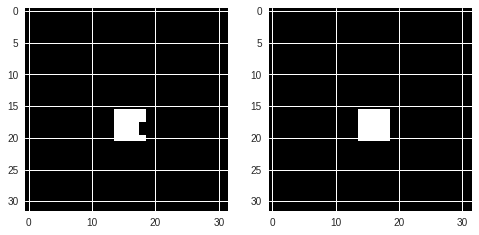

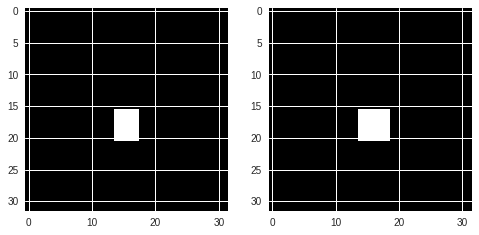

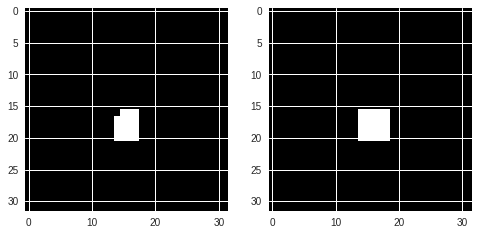

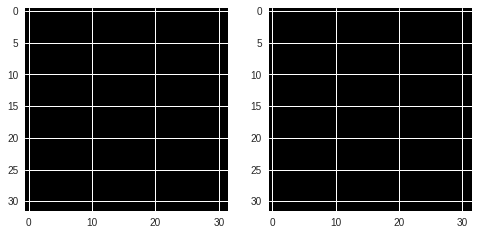

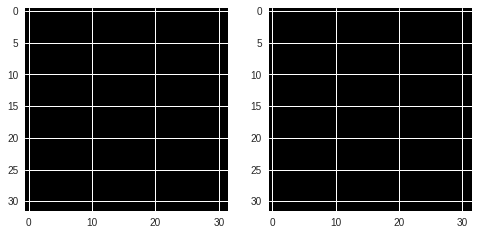

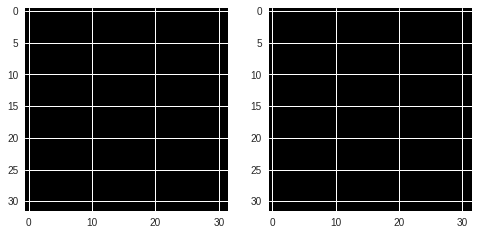

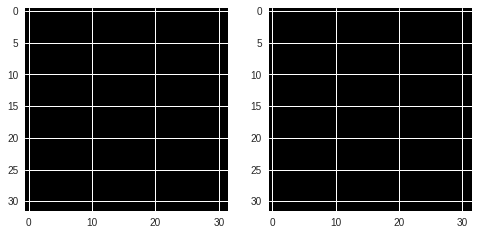

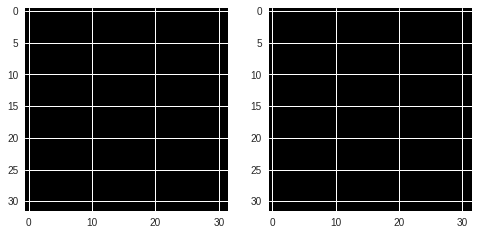

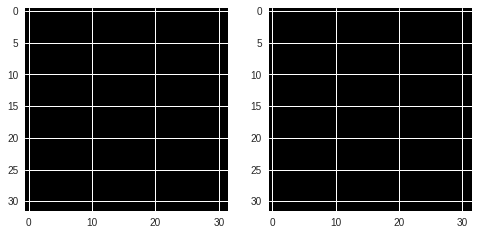

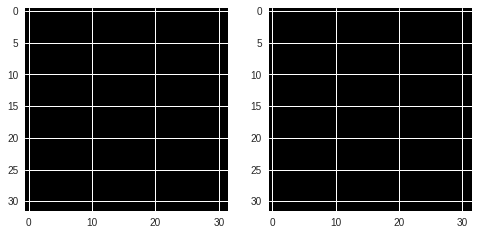

In [107]:
testnoise, labeltestnoise = gen_cubes_noise(n=5)
import tensorflow as tf
mean = 0
for j in range(5):
  prednoise = model_noise.predict(testnoise[None, j, :, : :] )
  #mean+=tf.Session().run(dice_coe((pred>0.5).astype('float32'), labeltest[0]))
  for i in range(16):
      plt.subplot(1, 2, 1)
      plt.imshow(prednoise[0, :, :, i, 0] > 0.5,  cmap = 'gray')
      plt.subplot(1, 2, 2)
      plt.imshow(labeltestnoise[j, :, :, i, 0], cmap = 'gray')
      plt.show()

In [47]:
 with open('test_500/pred14.pkl','rb') as f:
    x = pickle.load(f)
    print(x.shape)

(1, 128, 128, 64, 2)


In [6]:
def dice_coef(gt, pred):
    predf = np.ravel(pred)
    gtf = np.ravel(gt)
    print(gtf)
    inter = np.sum(predf*gtf)
    print(inter)
    union  = np.sum(predf) + np.sum(gtf)
    print(union)
    return 2*inter/union

In [48]:
 with open('labels.pkl','rb') as f:
    labels = pickle.load(f)
    print(labels.shape)


(50, 128, 128, 64)


0


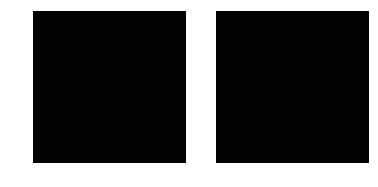

1


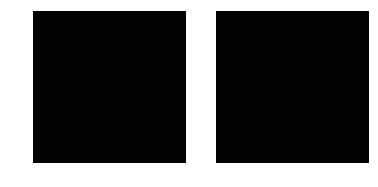

2


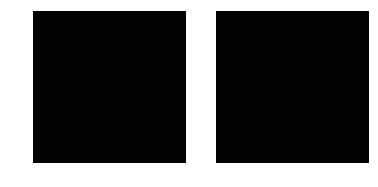

3


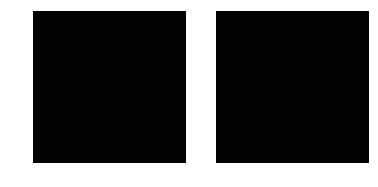

4


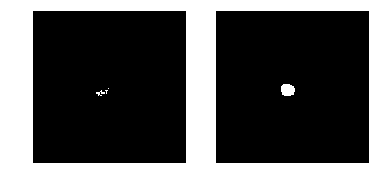

5


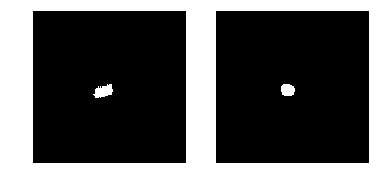

6


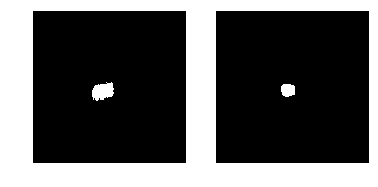

7


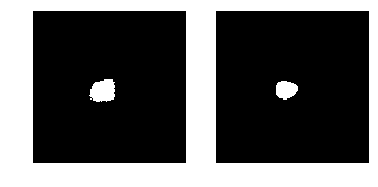

8


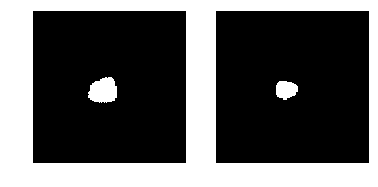

9


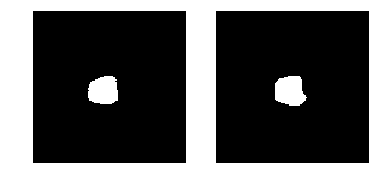

10


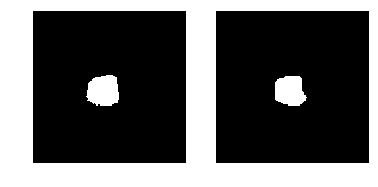

11


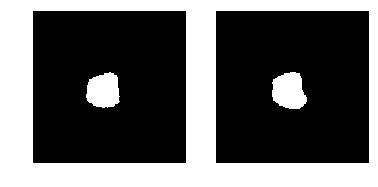

12


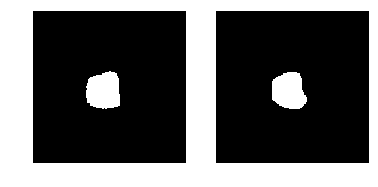

13


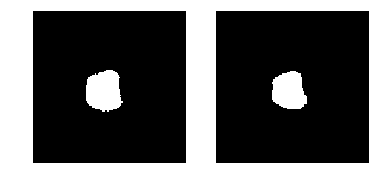

14


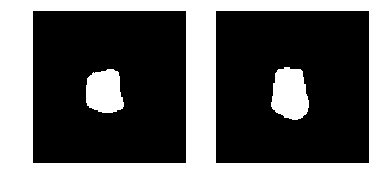

15


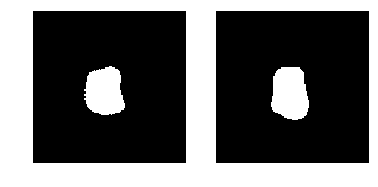

16


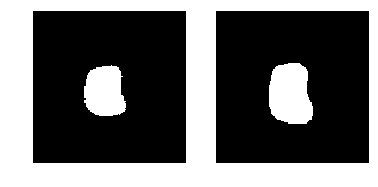

17


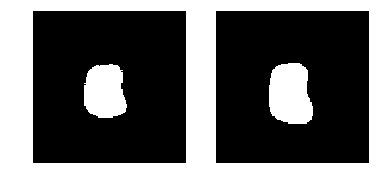

18


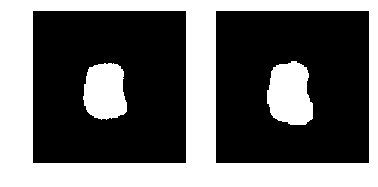

19


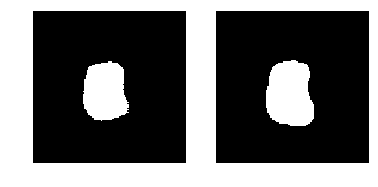

20


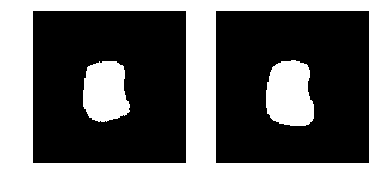

21


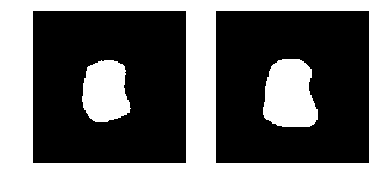

22


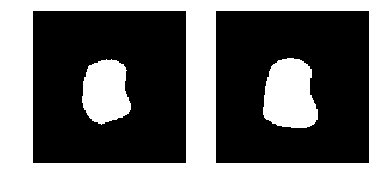

23


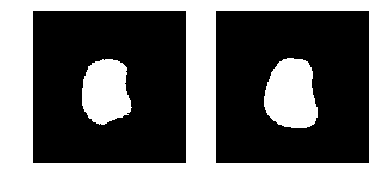

24


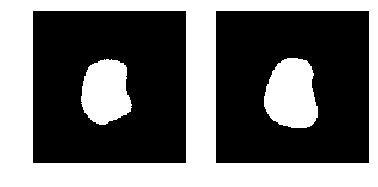

25


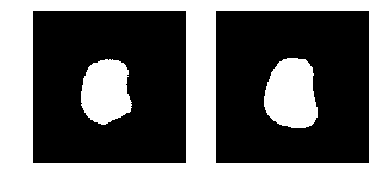

26


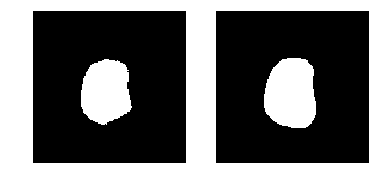

27


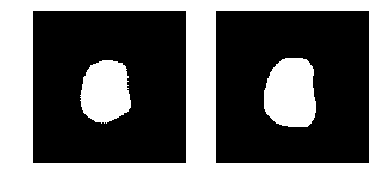

28


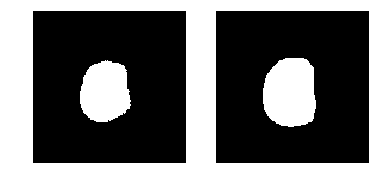

29


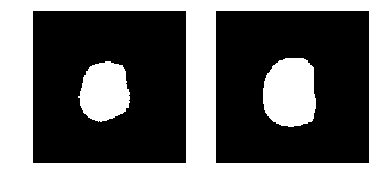

30


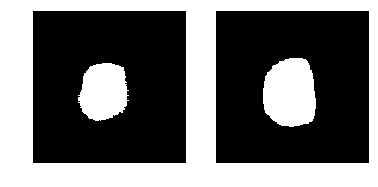

31


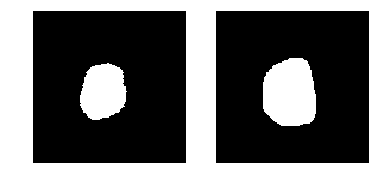

32


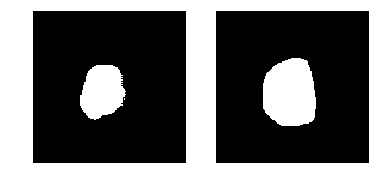

33


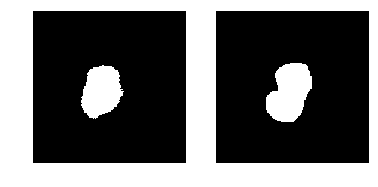

34


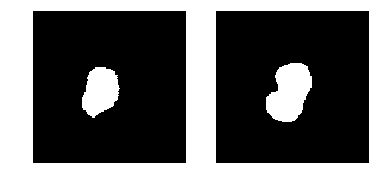

35


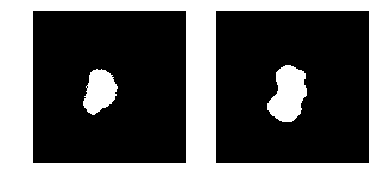

36


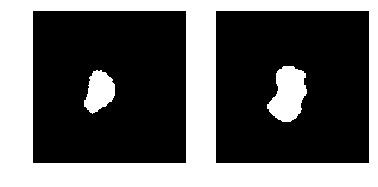

37


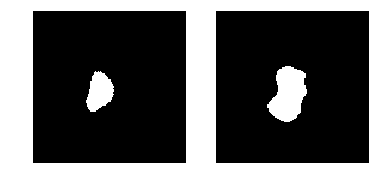

38


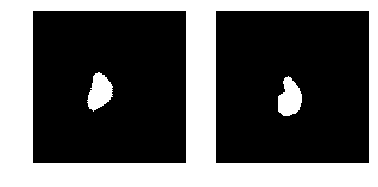

39


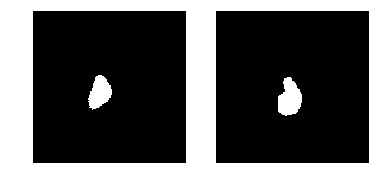

40


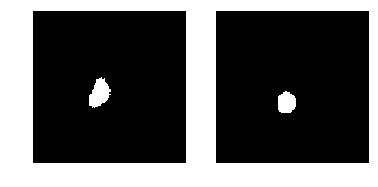

41


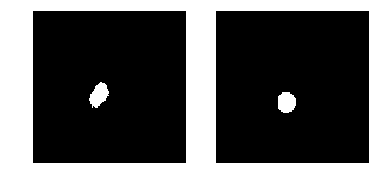

42


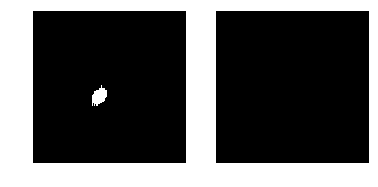

43


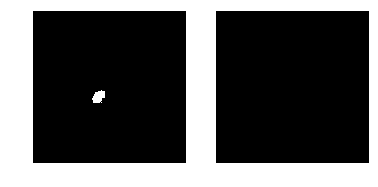

44


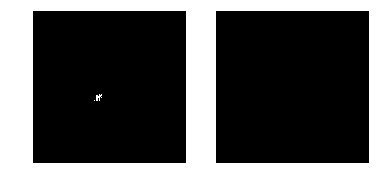

45


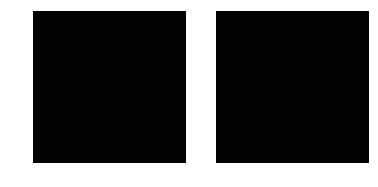

46


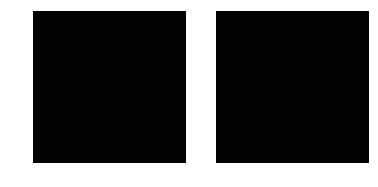

47


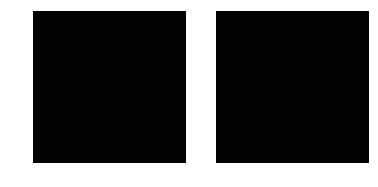

48


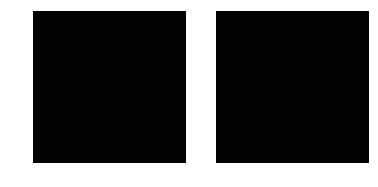

49


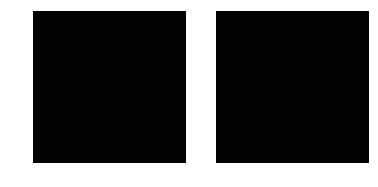

50


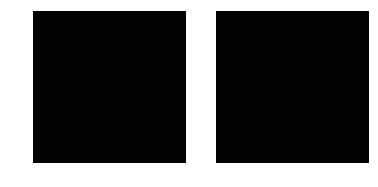

51


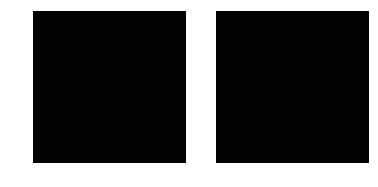

52


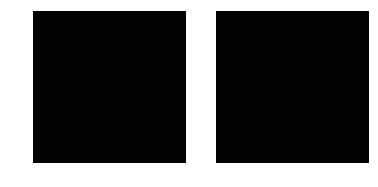

53


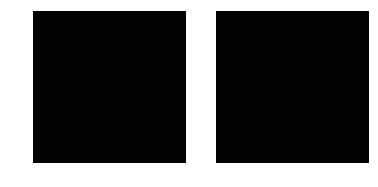

54


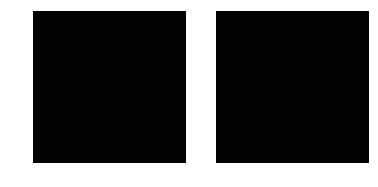

55


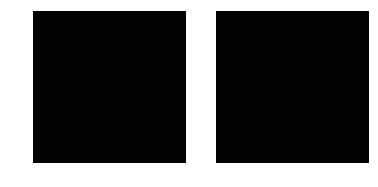

56


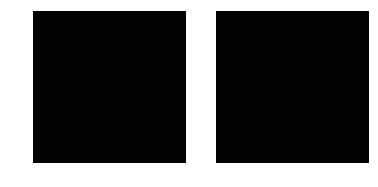

57


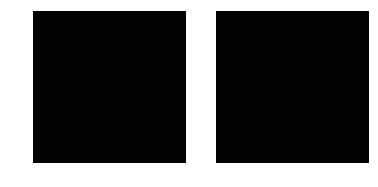

58


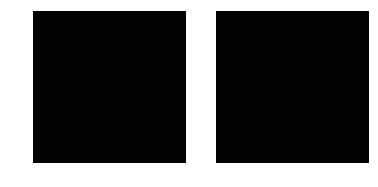

59


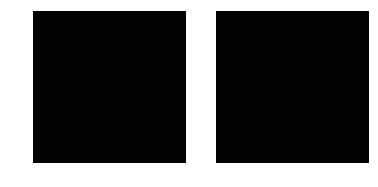

60


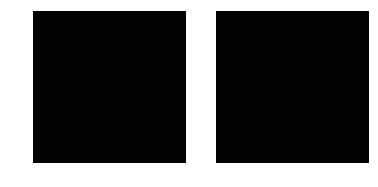

61


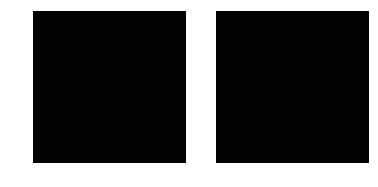

62


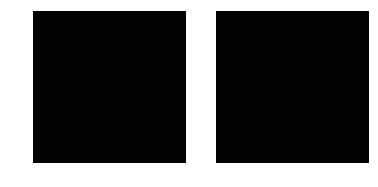

63


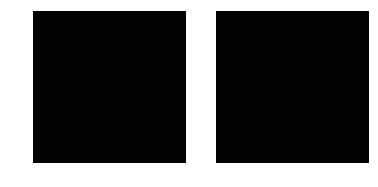

In [52]:
for i in range(64):
    print(i)
    plt.subplot(1, 2, 1)
    plt.imshow(x[0, :, :,i, 0]>0.6, cmap = 'gray')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(labels[14, :, :, i], cmap='gray')
    plt.axis('off')
    plt.show()

In [11]:
dice_coef(np.concatenate([labels[11, :, :, :], 1-labels[11, :, :, :]], axis=3), x)

[0. 1. 0. ... 1. 0. 1.]
1002579.4
2097152.0


0.9561342000961304

In [51]:
print x

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(x)? (<ipython-input-51-0b640320f694>, line 1)

In [62]:
print(x.shape)
print(x)

(1, 128, 128, 64, 2)
[[[[[2.69965287e-02 9.73003447e-01]
    [1.42682400e-02 9.85731781e-01]
    [6.75847428e-03 9.93241549e-01]
    ...
    [8.75913072e-03 9.91240919e-01]
    [1.99223533e-02 9.80077624e-01]
    [4.20922488e-02 9.57907736e-01]]

   [[1.66913010e-02 9.83308613e-01]
    [6.69244118e-03 9.93307531e-01]
    [2.53735739e-03 9.97462630e-01]
    ...
    [2.79734773e-03 9.97202635e-01]
    [8.91948678e-03 9.91080582e-01]
    [2.46189255e-02 9.75381076e-01]]

   [[8.60832538e-03 9.91391659e-01]
    [2.84324051e-03 9.97156739e-01]
    [8.69934622e-04 9.99130070e-01]
    ...
    [8.88924347e-04 9.99111116e-01]
    [3.44590424e-03 9.96554136e-01]
    [1.32894786e-02 9.86710489e-01]]

   ...

   [[1.07388087e-02 9.89261150e-01]
    [3.55326710e-03 9.96446788e-01]
    [1.20198913e-03 9.98798013e-01]
    ...
    [1.52441754e-03 9.98475611e-01]
    [4.74994909e-03 9.95249987e-01]
    [1.45483715e-02 9.85451639e-01]]

   [[2.03701463e-02 9.79629874e-01]
    [8.57937057e-03 9.91420627e

In [72]:
 np.concatenate([labels[5, :, :, :], 1-labels[5, :, :, :]], axis=3)

array([[[[0., 1.],
         [0., 1.],
         [0., 1.],
         ...,
         [0., 1.],
         [0., 1.],
         [0., 1.]],

        [[0., 1.],
         [0., 1.],
         [0., 1.],
         ...,
         [0., 1.],
         [0., 1.],
         [0., 1.]],

        [[0., 1.],
         [0., 1.],
         [0., 1.],
         ...,
         [0., 1.],
         [0., 1.],
         [0., 1.]],

        ...,

        [[0., 1.],
         [0., 1.],
         [0., 1.],
         ...,
         [0., 1.],
         [0., 1.],
         [0., 1.]],

        [[0., 1.],
         [0., 1.],
         [0., 1.],
         ...,
         [0., 1.],
         [0., 1.],
         [0., 1.]],

        [[0., 1.],
         [0., 1.],
         [0., 1.],
         ...,
         [0., 1.],
         [0., 1.],
         [0., 1.]]],


       [[[0., 1.],
         [0., 1.],
         [0., 1.],
         ...,
         [0., 1.],
         [0., 1.],
         [0., 1.]],

        [[0., 1.],
         [0., 1.],
         [0., 1.],
         ...,
   

In [87]:
print(np.where((x[:, :, :, :, 0] > 0.5) == True))

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))


In [35]:
loss = []
with open("loss_history.txt", 'r') as f:
    for line in f:
        loss+=[float(line)]

Text(0,0.5,'Dice-based loss')

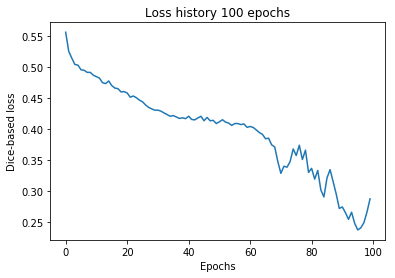

In [39]:
plt.plot(loss)
plt.title("Loss history 100 epochs")
plt.xlabel('Epochs')
plt.ylabel('Dice-based loss')

In [38]:
loss

[0.5555685559908549,
 0.5247808085547553,
 0.5138139976395502,
 0.5036764144897461,
 0.5026455375883314,
 0.4951393445332845,
 0.49439050091637504,
 0.4910356667306688,
 0.49098105165693495,
 0.48645370536380345,
 0.4841062664985657,
 0.4817161851459079,
 0.47433692879147,
 0.4729717387093438,
 0.4771703879038493,
 0.4697291692097982,
 0.4657416555616591,
 0.4648041115866767,
 0.45956162611643475,
 0.4600106358528137,
 0.4578946563932631,
 0.45112402704026966,
 0.4529868735207452,
 0.450252460108863,
 0.44629633691575793,
 0.4436692198117574,
 0.4385277920299106,
 0.4346354802449544,
 0.4321896619266934,
 0.4301634165975783,
 0.430264683564504,
 0.4286044173770481,
 0.4257160769568549,
 0.42310913271374173,
 0.4203826692369249,
 0.4215086023012797,
 0.41920730140474105,
 0.416902854707506,
 0.41792844269010754,
 0.41651117669211496,
 0.42043313185373943,
 0.4152131875356038,
 0.4145822935634189,
 0.4176877432399326,
 0.42034599118762545,
 0.4131858163409763,
 0.41850671238369413,
 0.41

In [53]:
loss = []
with open("loss500.txt", 'r') as f:
    for line in f:
        loss+=[float(line)]

Text(0,0.5,'Dice-based loss')

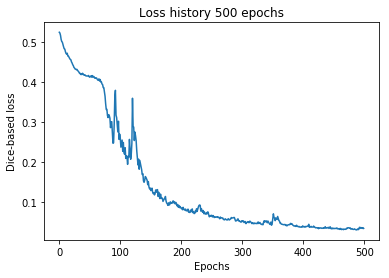

In [54]:
plt.plot(loss)
plt.title("Loss history 500 epochs")
plt.xlabel('Epochs')
plt.ylabel('Dice-based loss')